# PRP325 Reach Analysis

## Current Open Questions (10/14/2024)

- Where exactly is Dren Huizaches? Is it [here](https://www.openstreetmap.org/way/755761731#map=16/26.23125/-98.65997)? [Overpass turbo query](https://overpass-turbo.eu/map.html?Q=%2F*%0AThis+query+selects+all+possible+waterways%2C+storm+drains%2C+and+bodies+of+water%2C+including+small+features+like+ponds%2C+pools%2C+and+wetlands.%0AIt+also+labels+the+regions+and+marks+points+of+intersection.%0A*%2F%0A%0A%5Bout%3Ajson%5D%5Btimeout%3A25%5D%3B%0A%0A%2F%2F+Use+the+current+map+view%27s+bounding+box%0A%28%0A++%2F%2F+Select+all+waterways+%28rivers%2C+streams%2C+canals%2C+etc.%29%0A++way%5B%22waterway%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%3B%0A++%0A++%2F%2F+Select+storm+drains+and+ditches%0A++way%5B%22man_made%22%3D%22storm_drain%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%3B%0A++way%5B%22waterway%22%3D%22drain%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%3B%0A++way%5B%22waterway%22%3D%22ditch%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%3B%0A++%0A++%2F%2F+Select+all+bodies+of+water+%28lakes%2C+reservoirs%2C+ponds%2C+pools%2C+wetlands%29%0A++way%5B%22natural%22%3D%22water%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%3B%0A++way%5B%22water%22%3D%22lake%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%3B%0A++way%5B%22water%22%3D%22reservoir%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%3B%0A++way%5B%22water%22%3D%22pond%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%3B%0A++%0A++%2F%2F+Include+wetlands%0A++way%5B%22natural%22%3D%22wetland%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%3B%0A++%0A++%2F%2F+Include+swimming+pools%0A++way%5B%22leisure%22%3D%22swimming_pool%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%3B%0A++%0A++%2F%2F+Include+basins%0A++way%5B%22landuse%22%3D%22basin%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%3B%0A++%0A++%2F%2F+Include+bays+or+lagoons%0A++way%5B%22natural%22%3D%22bay%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%3B%0A%29%3B%0A%0A%2F%2F+Output+the+geometries+with+names%0Aout+body%3B%0A%3E%3B%0Aout+skel+qt%3B%0A%0A%2F%2F+Find+intersections+by+looking+for+nodes+shared+between+different+water-related+features%0A%28%0A++node%28w%5B%22waterway%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%29%3B%0A++node%28w%5B%22man_made%22%3D%22storm_drain%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%29%3B%0A++node%28w%5B%22natural%22%3D%22water%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%29%3B%0A++node%28w%5B%22natural%22%3D%22wetland%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%29%3B%0A++node%28w%5B%22leisure%22%3D%22swimming_pool%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%29%3B%0A++node%28w%5B%22landuse%22%3D%22basin%22%5D%2826.10920376334051%2C-98.82030487060548%2C26.39156213147266%2C-98.45809936523439%29%29%3B%0A%29+-%3E+.intersectionNodes%3B%0A%0A%2F%2F+Output+the+intersection+nodes%0Anode.intersectionNodes%3B%0Aout%3B%0A). Also is there a release schedule?
- 

## Working Notes

- General procedure: Get data sources -> clean the data -> run models for time synchronization/mass balance -> run graphical analysis -> run data analysis -> build hypotheses -> run a regression analysis to determine correlation -> derive explanations
- 

## Goals

- Generate a series of well-formatted graphs that can provide a cursory analysis on the output from the OASIS model.
- Run summary statistical analysis on the time series
- Test certain hypotheses to see if they hold up

## Getting started

This project is managed with [Rye](https://rye.astral.sh/), follow the instructions there to get up and running with all the dependencies.

After installing the dependencies, you can just execute this notebook

![ref.png](ref.png)

In [1]:
# Meta functions

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import statements
import sqlite3
import pandas as pd
import numpy as np

from src.lib import utils
from src.lib import stats
from src.lib import plot
from src.lib import analysis

In [40]:
# Global variables
pd.set_option('display.max_rows', 1000)

field_names = [
    "Upstream200.250",
    "DrenIndiosPuertecitos235.250",
    "Precipitation257.250",
    "DrenHuizaches285.300",
    "DrenMorrillo295.300",
    # "GDOrdaz250.230",  # This is constant so I'm excluding it
    "UpperDemandTX250.240",
    "Evaporation250.255",
    "Phreatophyte250.245",
    "Downstream250.300",
    "Anzaldues300.280",
    "LowerDemandTX300.275",
    "MassBalance299.300",
    "MassBalanceOut300.298",
    "MassBalanceBalance300",
    "Salinity300",  # out
    "Salinity200",  # in
    "SalinityDrenPuertecitos",
    "SalinityDrenMorillo",
    "SalinityDrenHuizaches",
    "OtherInflow",
    "OtherOutflow",
    "FlowRetentionRate",
    "MassBalanceError"
]

## Getting the data

Some of this process is manual since OASIS does time sync, unit conversion and mass balance calculations.

- Get the data from OASIS using an uploaded `.1v` file. (Use the example `reach2_example.1v` and modify for your reach)
- Copy and paste the output data into `data/mass_balance_data.csv`.
- Run `rye run oasis2sqlite --csv data/mass_balance_data.csv --db mass_balance.sqlite`

### Fields Guide

**Note this includes computed fields from SQLite

| Field Name | Formula | Description |
|------------|---------|-------------|
| UpstreamFromR1 | flow200.250 | Inflow from upstream |
| IndiosPuertecitos | flow235.250 | Inflow from Indios Puertecitos |
| Precipitation | flow257.250 * 10| Precipitation input |
| DrenHuizaches | flow285.300 | Inflow from Dren Huizaches |
| DrenMorrillo | flow295.300 | Inflow from Dren Morrillo |
| GDOrdaz | -flow250.230 | Outflow to GD Ordaz |
| UpperDemandTX | -flow250.240 | Upper demand for Texas |
| Evaporation | -flow250.255 | Evaporation loss |
| PhreatophyteDemand | -flow250.245 | Phreatophyte water demand |
| DownstreamToR3 | -flow250.300 | Outflow downstream to R3 |
| AnzalduasCanal | -flow300.280 | Outflow to Anzalduas Canal |
| LoDemandTX | -flow300.275 | Lower demand for Texas |
| MassBalance | flow299.300 | Mass balance inflow |
| MassBalanceOut | -flow300.298 | Mass balance outflow |
| MassBalanceBalance | flow299.300 - flow300.298 | Net mass balance |
| SalinityOut | Timesers(arriba_anzalduas/salinity) | Salinity at outflow |
| SalinityIn | Timesers(rgccmb/salinity) | Salinity at inflow |
| SalinityDrenPuertecitos | Timesers(puertecitos/salinity) | Salinity at Dren Puertecitos|
| SalinityMorillos | Timesers(morillos/salinity) | Salinity at Dren Morillo |
| SalinityHuizaches | Timesers(huizaches/salinity) | Salinity at Dren Huizaches |
| OtherInflow | DrenIndiosPuertecitos235.250 + DrenHuizaches285.300 + DrenMorrillo295.300 | Sum of other inflows |
| OtherOutflow | Phreatophyte250.245 + UpperDemandTX250.240 + LowerDemandTX300.275 + Evaporation250.255 | Sum of other outflows |
| FlowRetentionRate | (Downstream250.300 + Upstream200.250) / Upstream200.250 * 100 | Flow retention rate as a percentage |
| MassBalanceError | MassBalance299.300 - MassBalanceOut300.298 - MassBalanceBalance300 | Calculated mass balance error |



In [4]:
# Connect to the database
conn = sqlite3.connect("mass_balance.sqlite")

In [5]:
df = utils.sqlite2df(conn, "mass_balance")

In [34]:
# Clean the data
df = df.dropna()
df = df.replace(0.0, 1e-9)

# Graphical Analysis

## Observations

- This was an extra [rainy year](https://www.weather.gov/media/bro/wxevents/2021/pdf/RGV2021SummerSummary.pdf)
- Anzalduas Dam had large outflows that I'm guessing corresponded with the [planting season](https://hidalgo.agrilife.org/files/2020/09/Vegetable-Planting-Guide-for-Rio-Grande-Valley.pdf)
- MassBalanceOut heavily correlates with MassBalanceError... is this a result of the formula, or is there an error in the model?

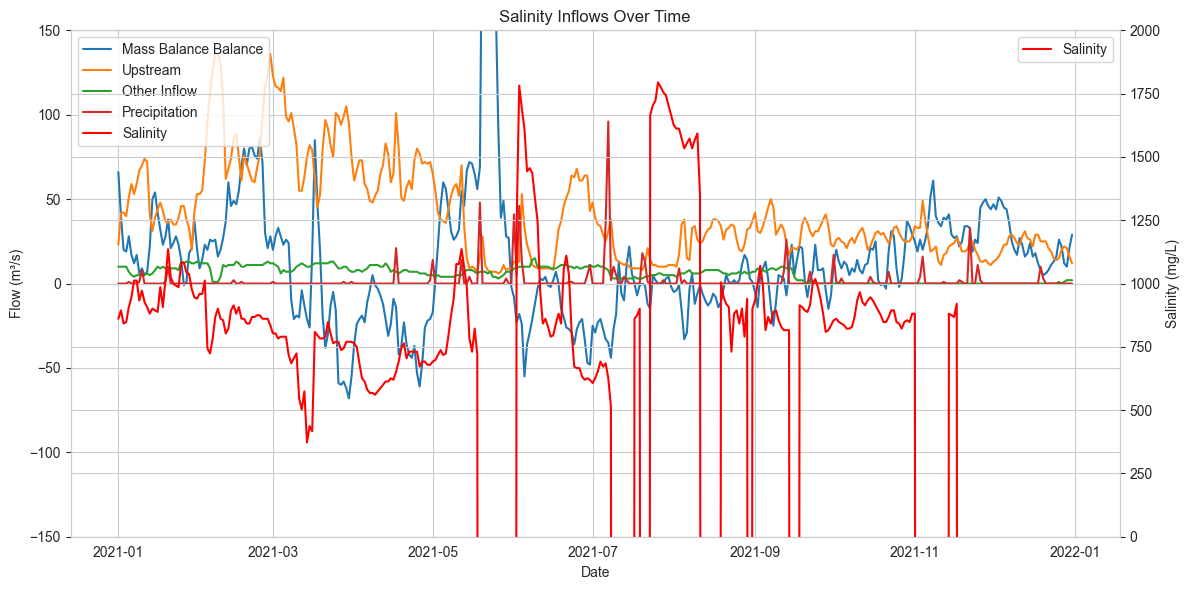

In [6]:
plot.get_inflow_salinity(conn)

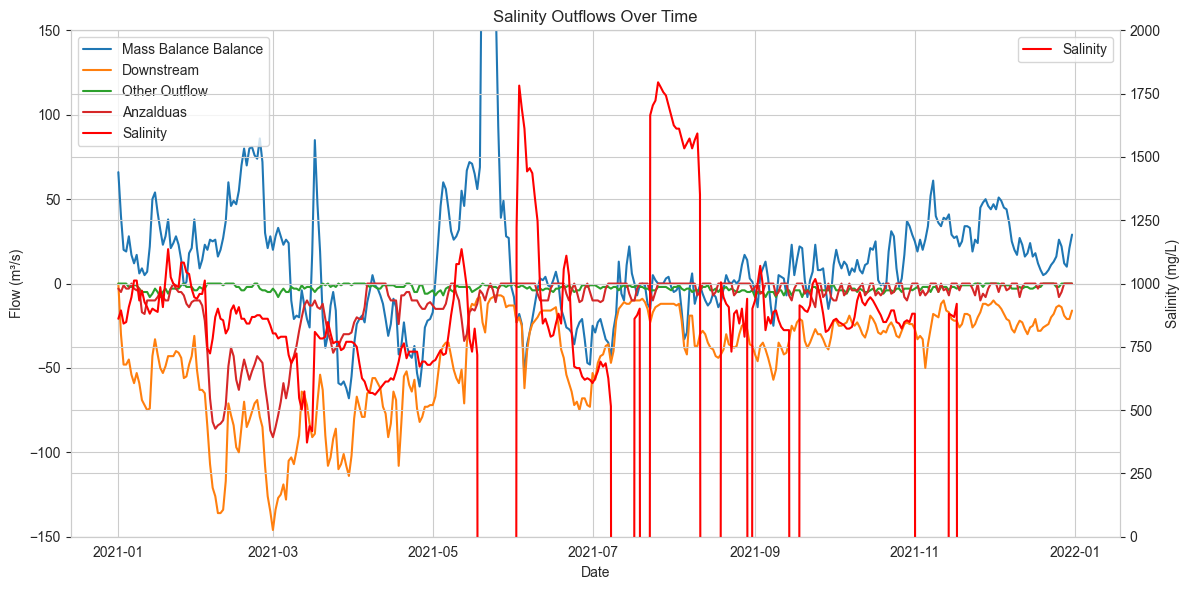

In [7]:
plot.get_outflow_salinity(conn)

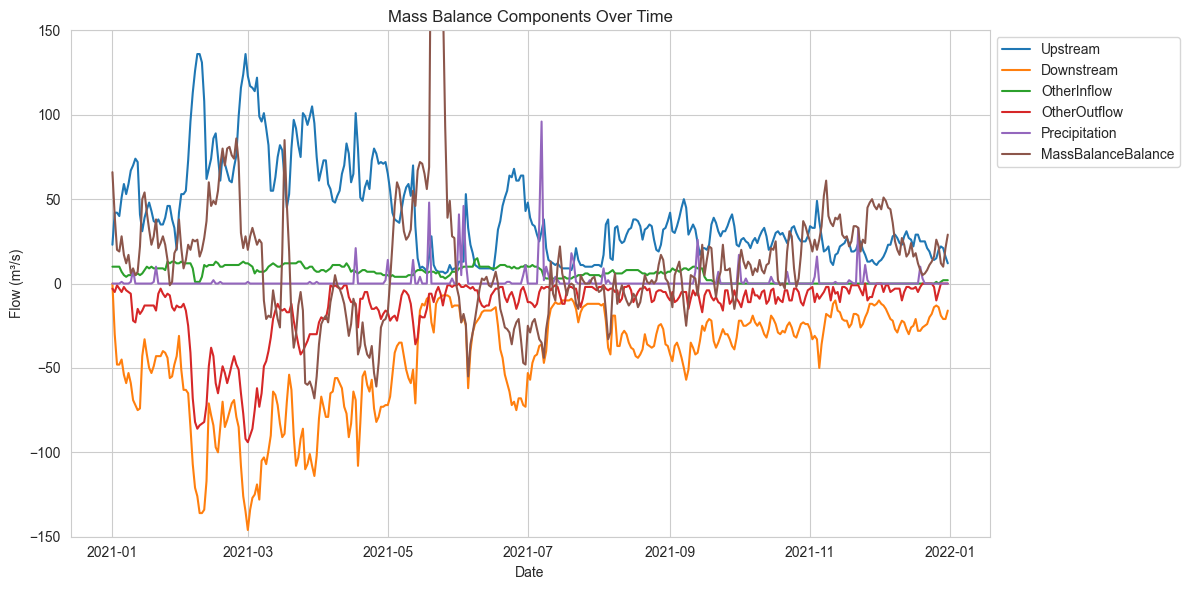

In [8]:
plot.mass_balance(conn)

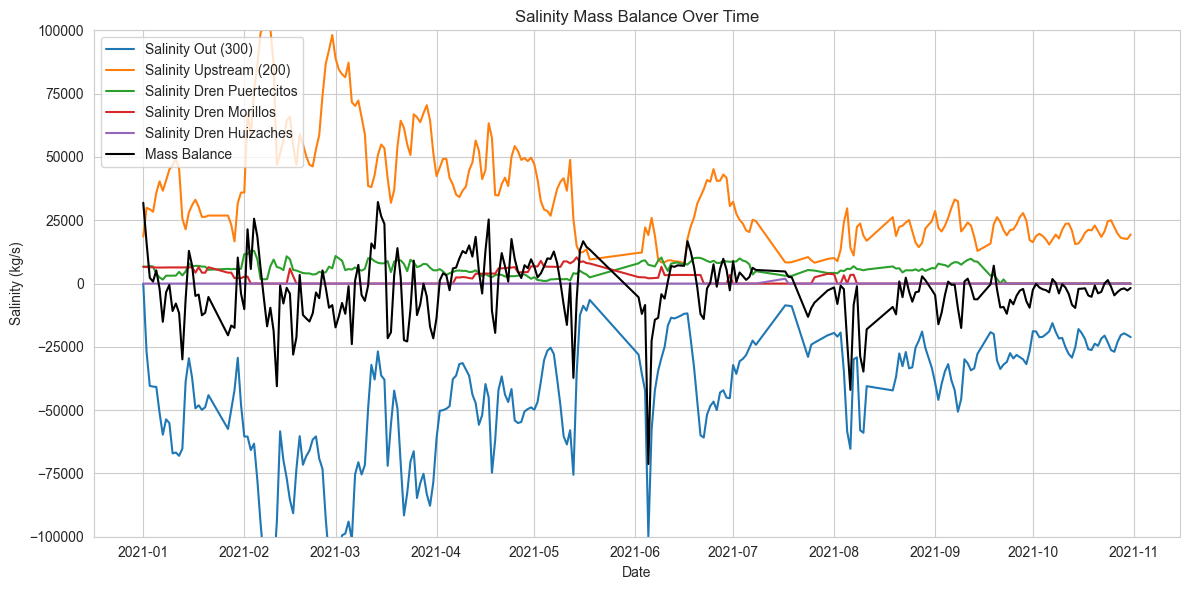

In [57]:
plot.plot_salinity_mass_balance(df)

# Data Analysis

## Goals

- Investigate the nature of the components
- Understand the null values or if there is bad data
- Assert model correctness

## Observations

- Most of the data is not normally distributed
- Some of the data is nonstationary (meaning there are trends/seasonality); Evaporation, Phreatophytes, Dren Morrillo, Downstream. I bet that a wider timescale would reveal more seasonality
- For the stationary data, series auto-correlat heavily with a day or two lag. This makes sense because it takes time for water to move
- The partial autocorrelation of Dren Huizaches indicates scheduled releases

In [9]:
stats.check_missing_values(df)

Salinity300                92
SalinityDrenPuertecitos    29
SalinityDrenMorillos       32
SalinityDrenHuizaches       8
dtype: int64

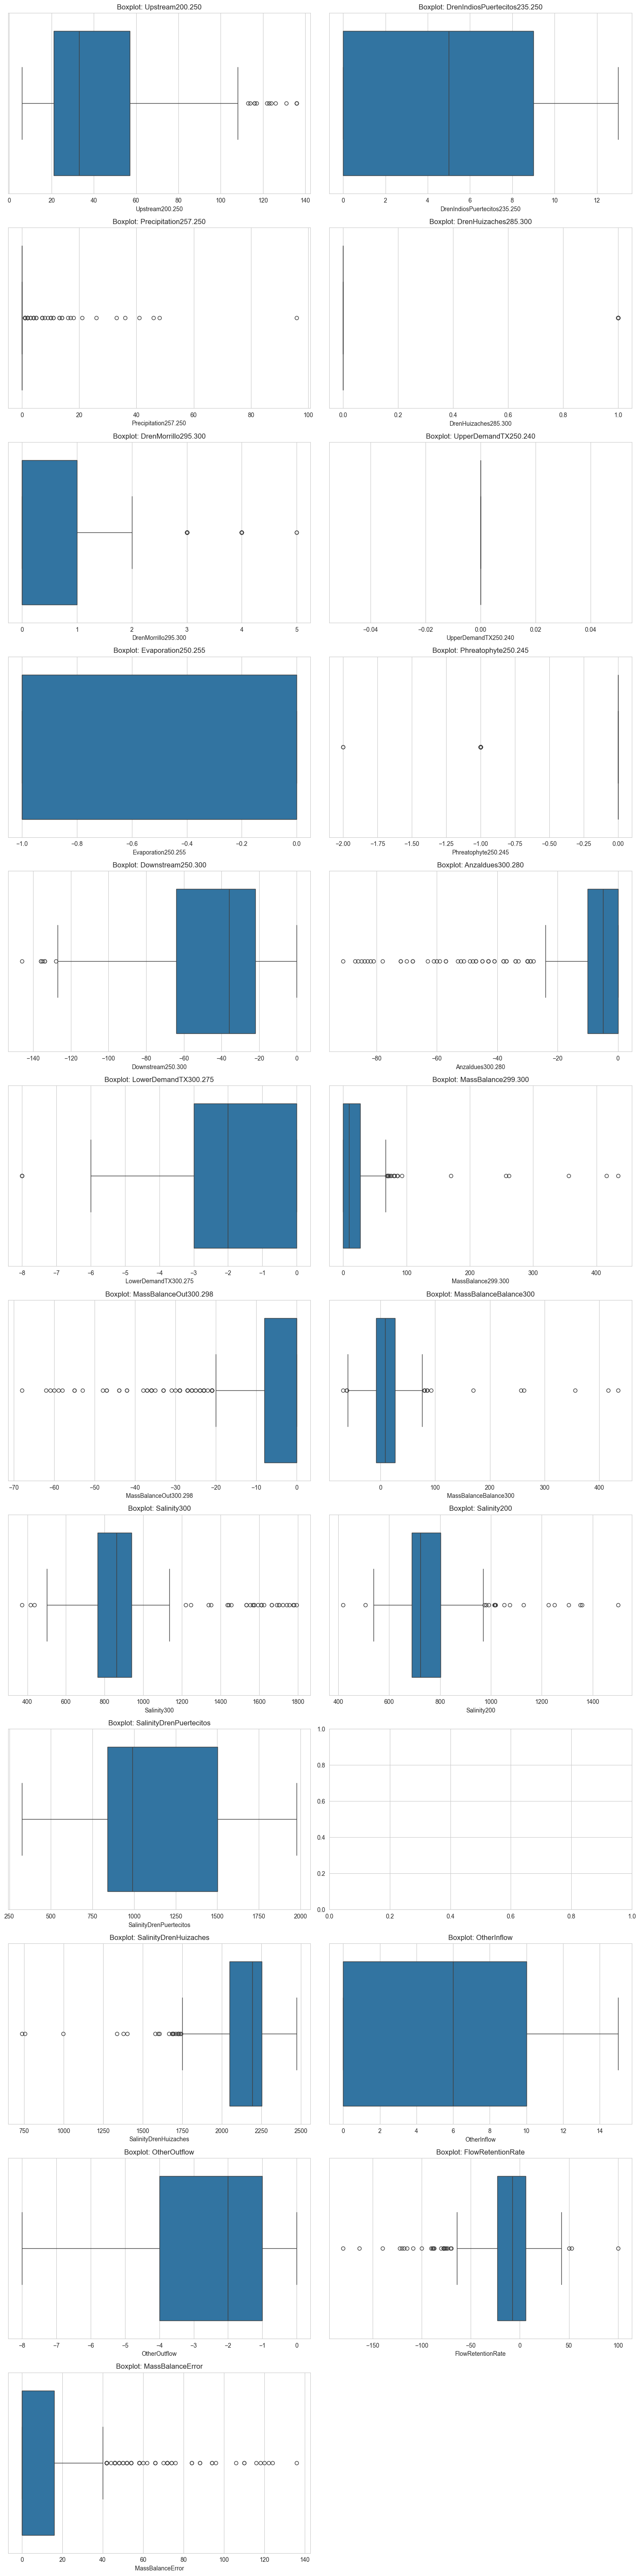

In [10]:
stats.plot_boxplot(df, field_names)

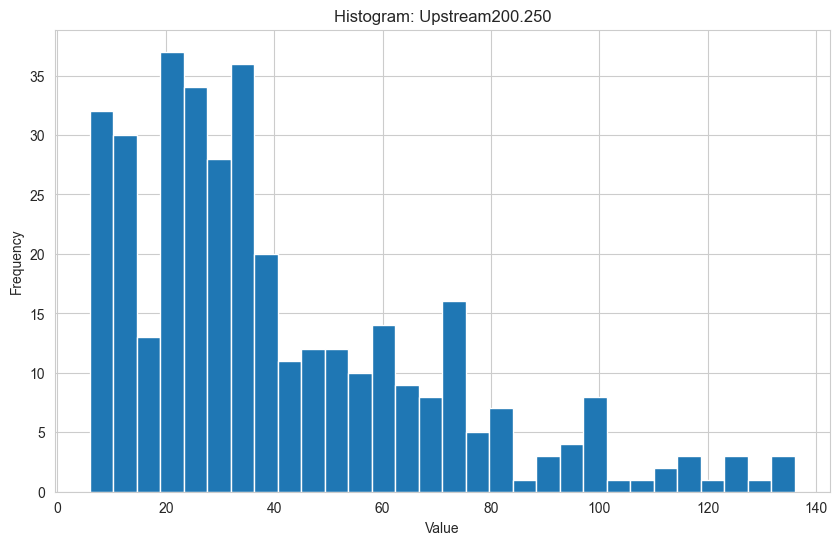

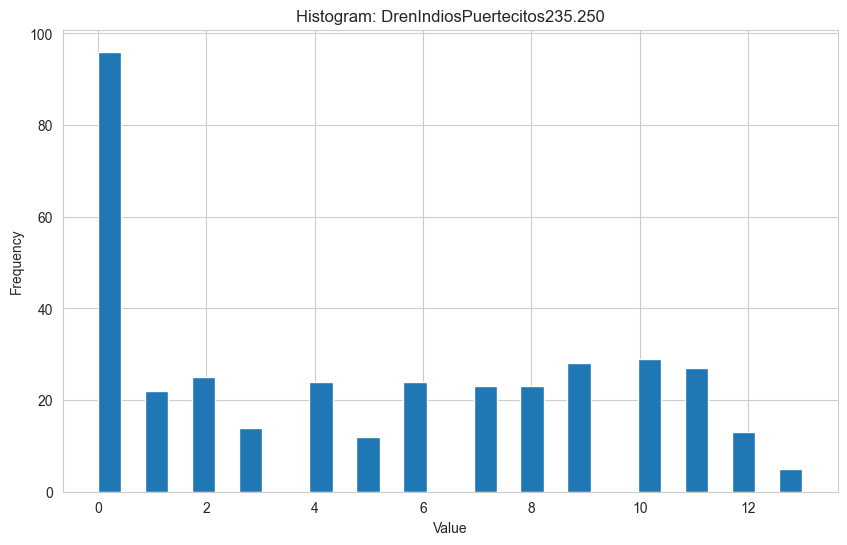

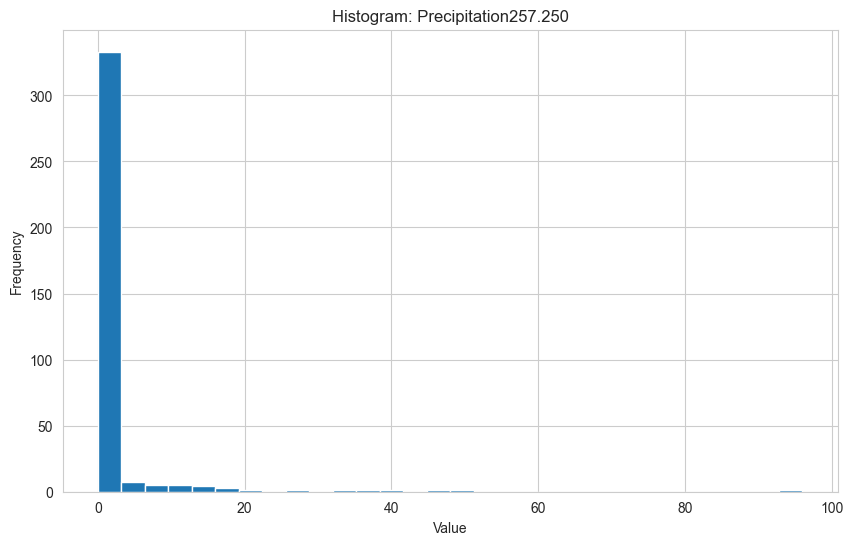

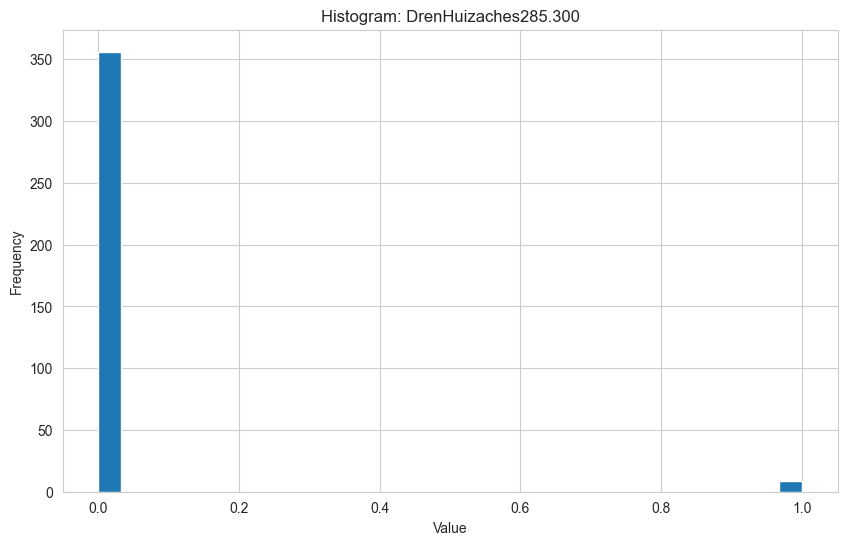

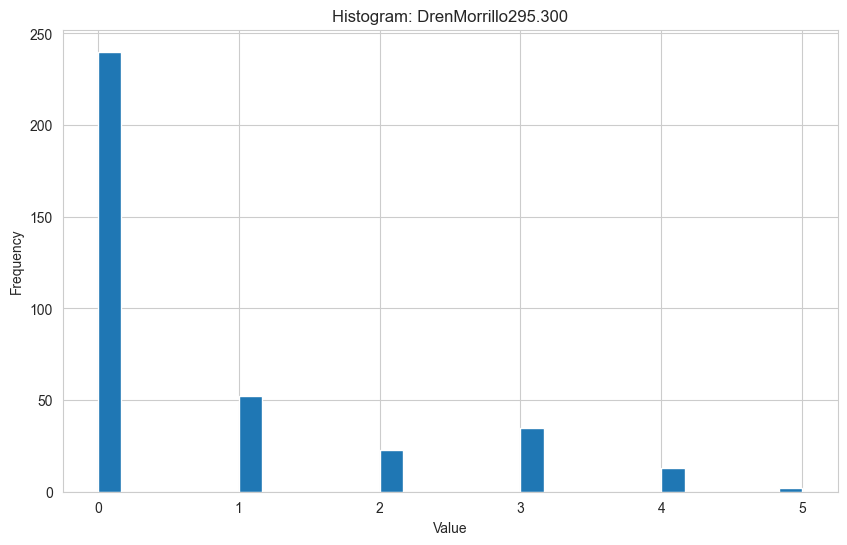

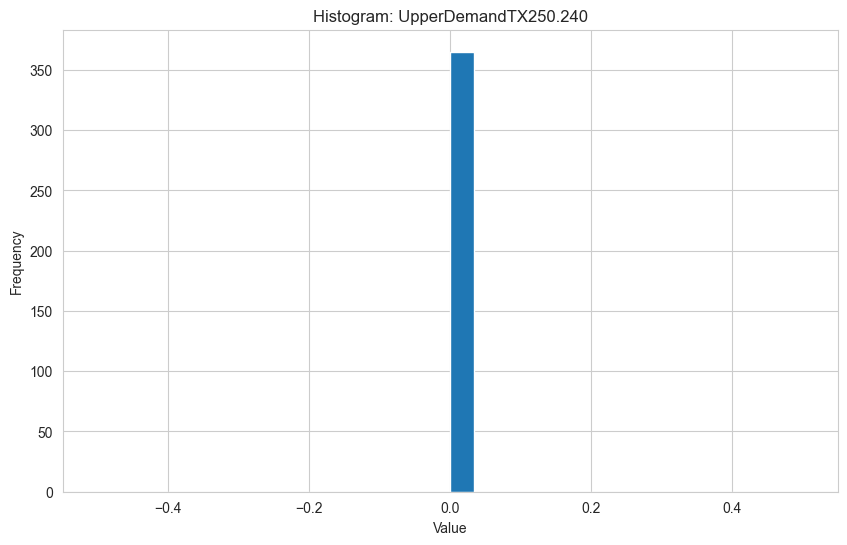

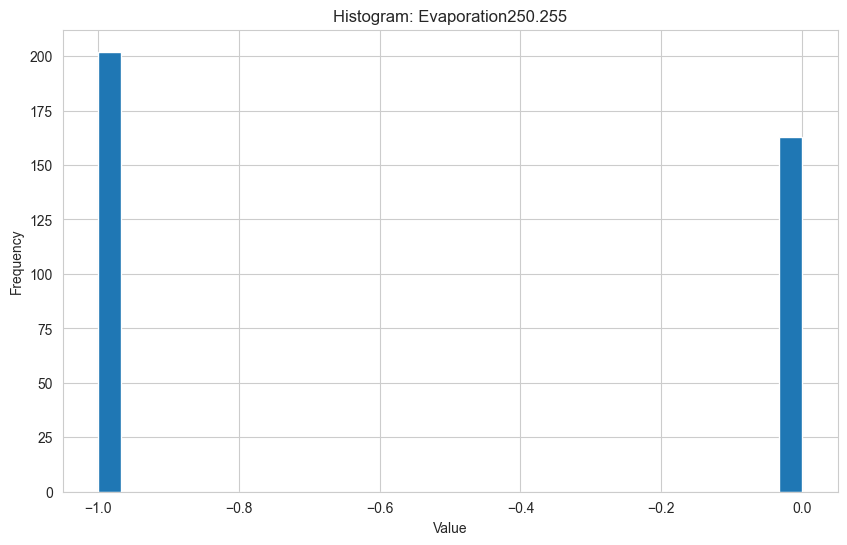

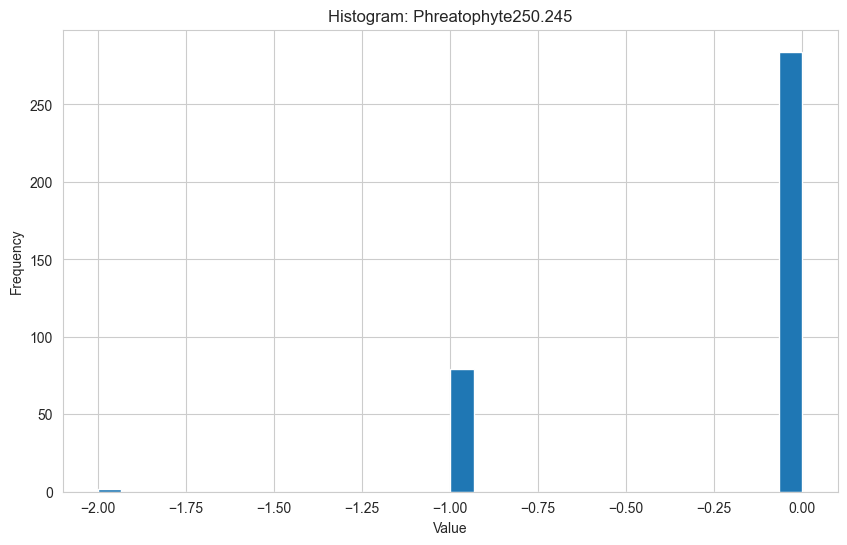

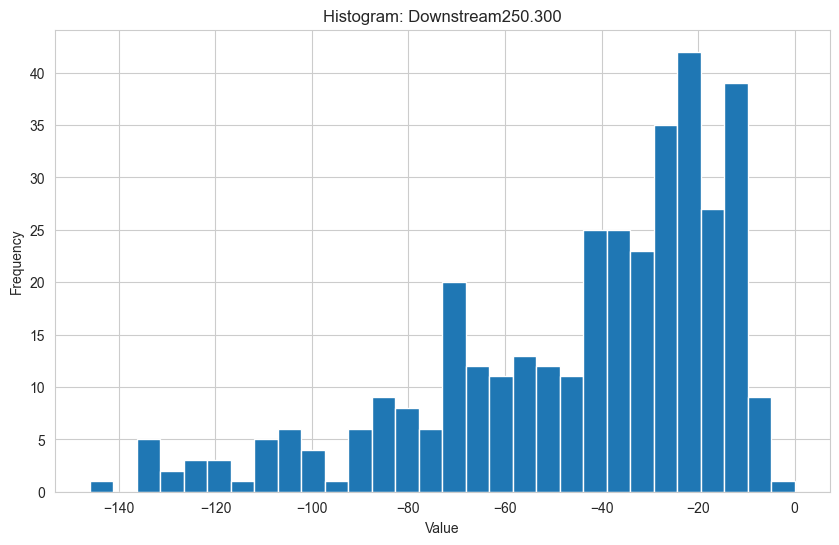

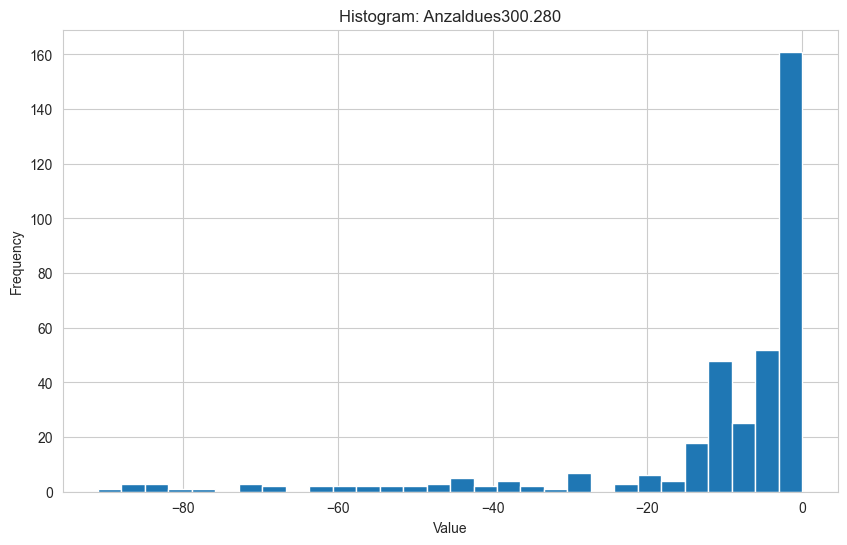

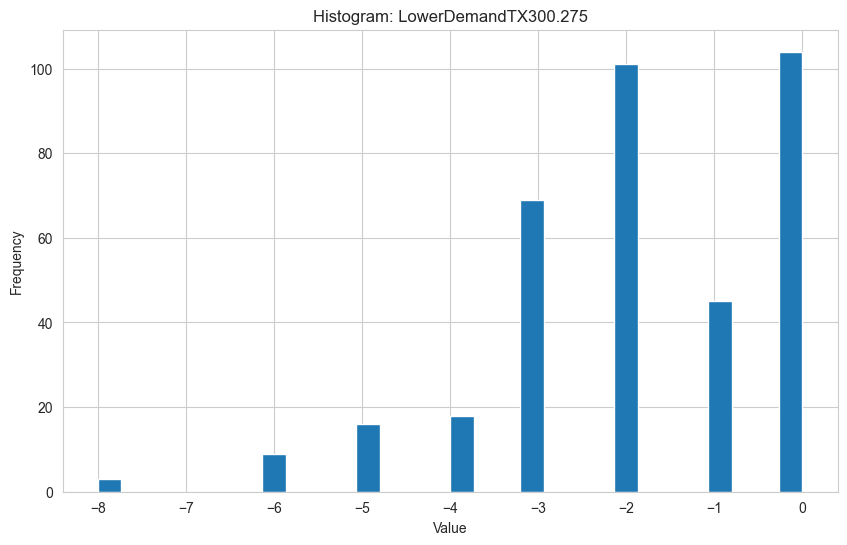

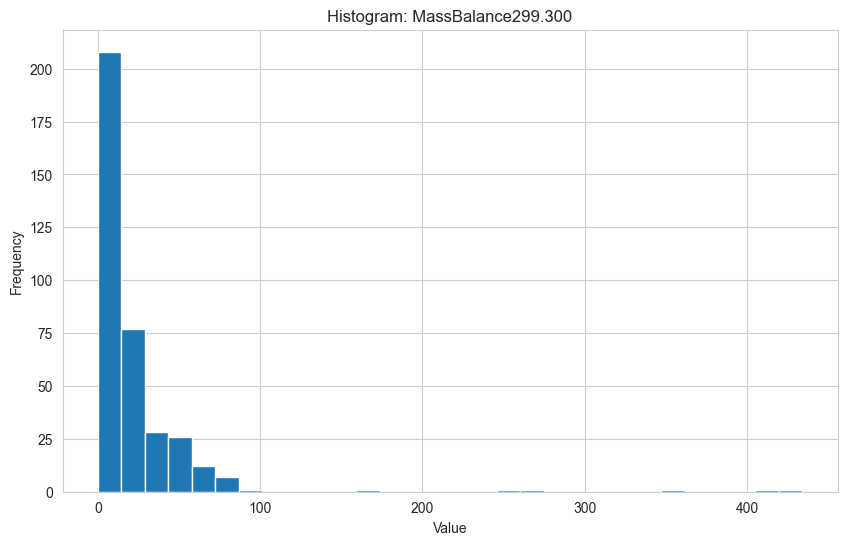

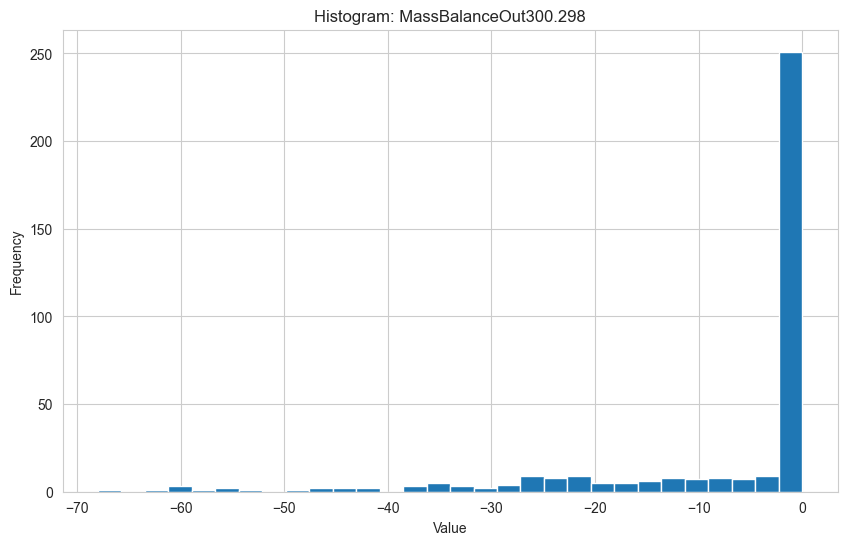

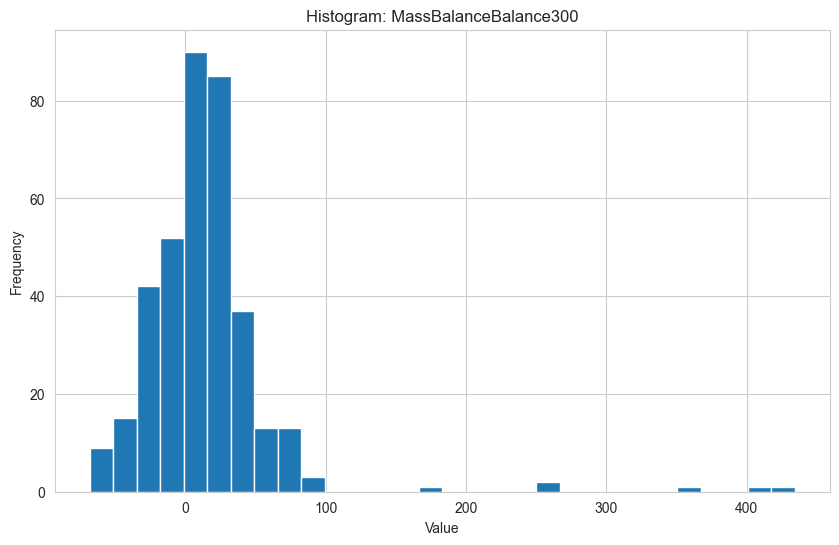

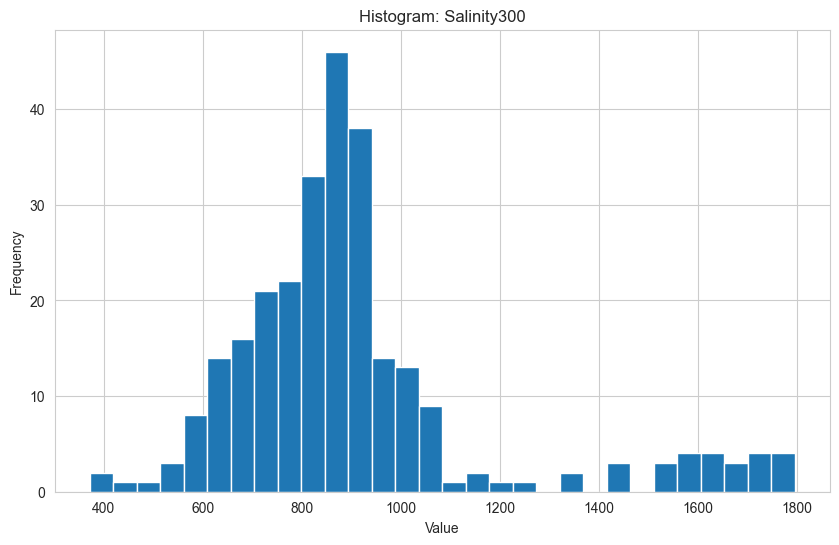

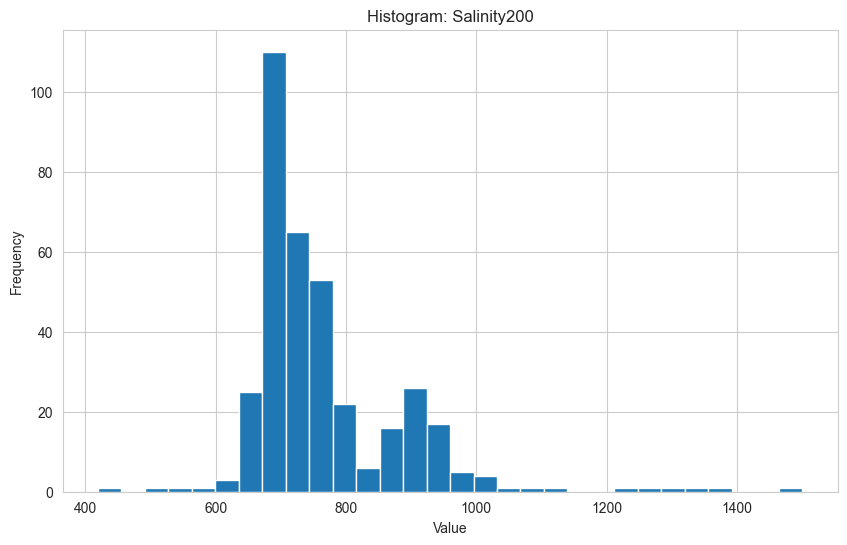

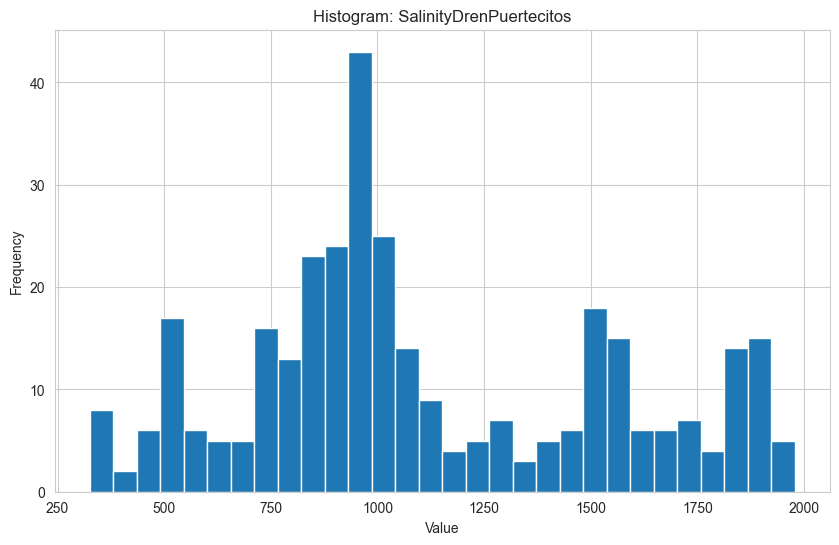

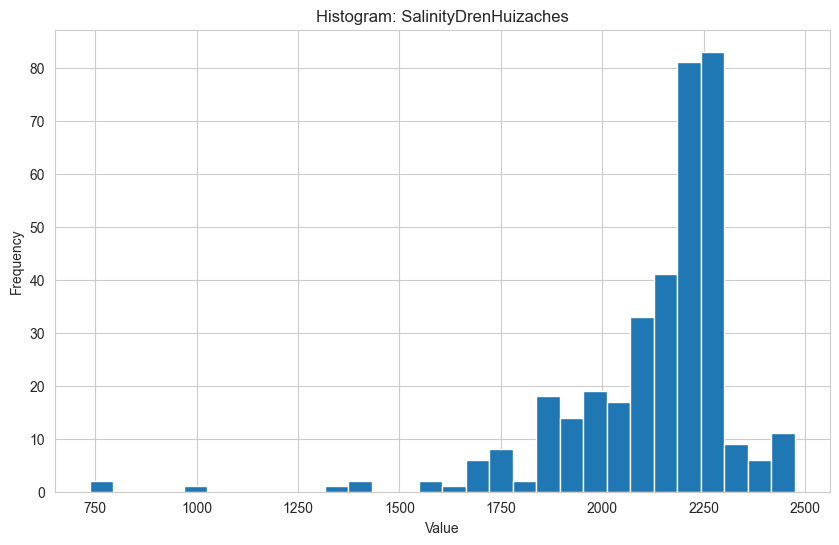

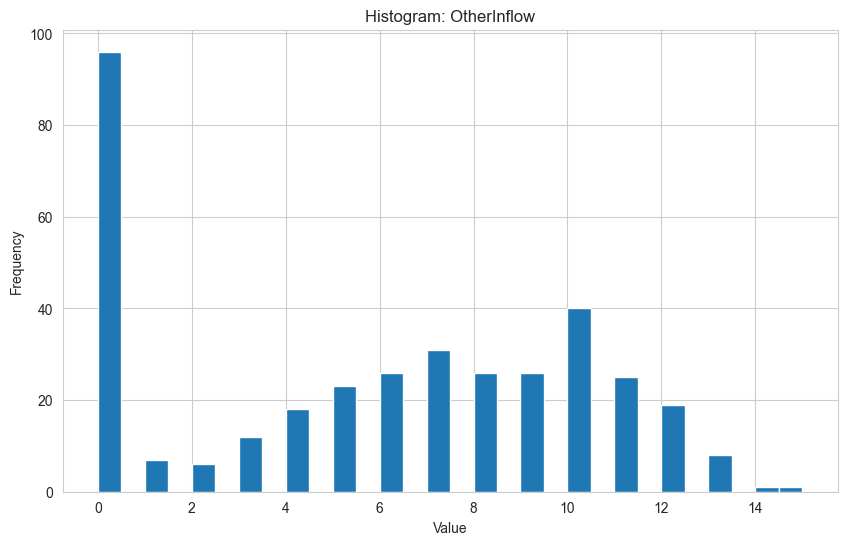

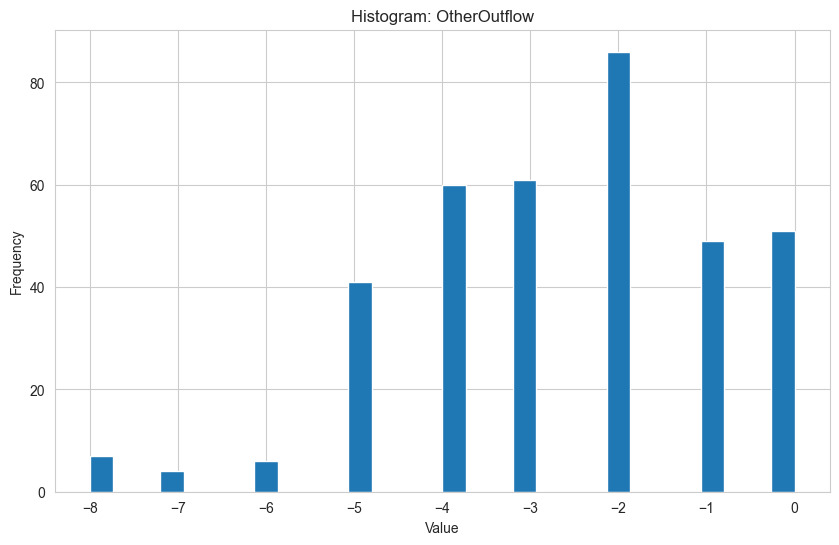

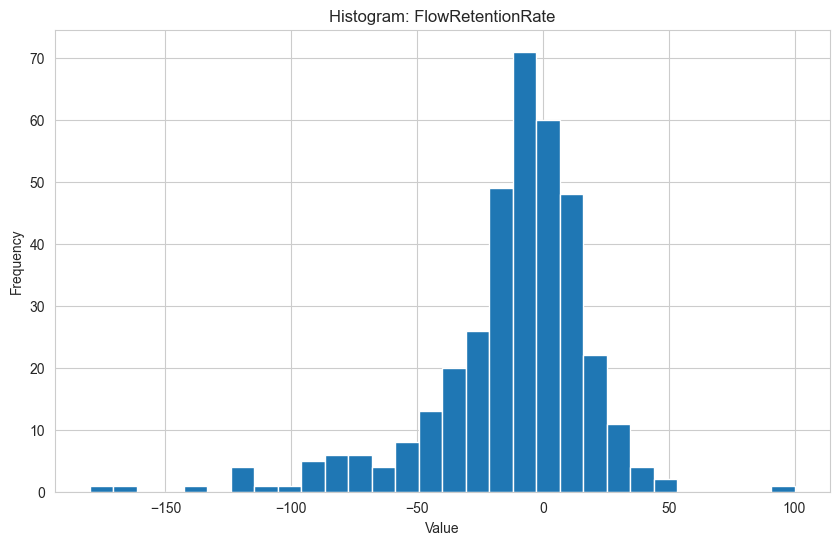

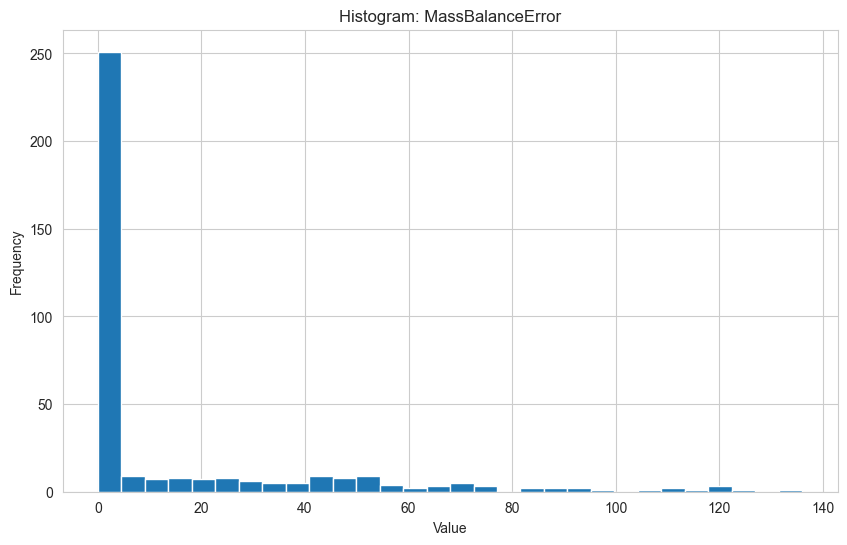

In [11]:
for fn in field_names:
    if fn in df.columns:
        stats.plot_histogram(df, fn)

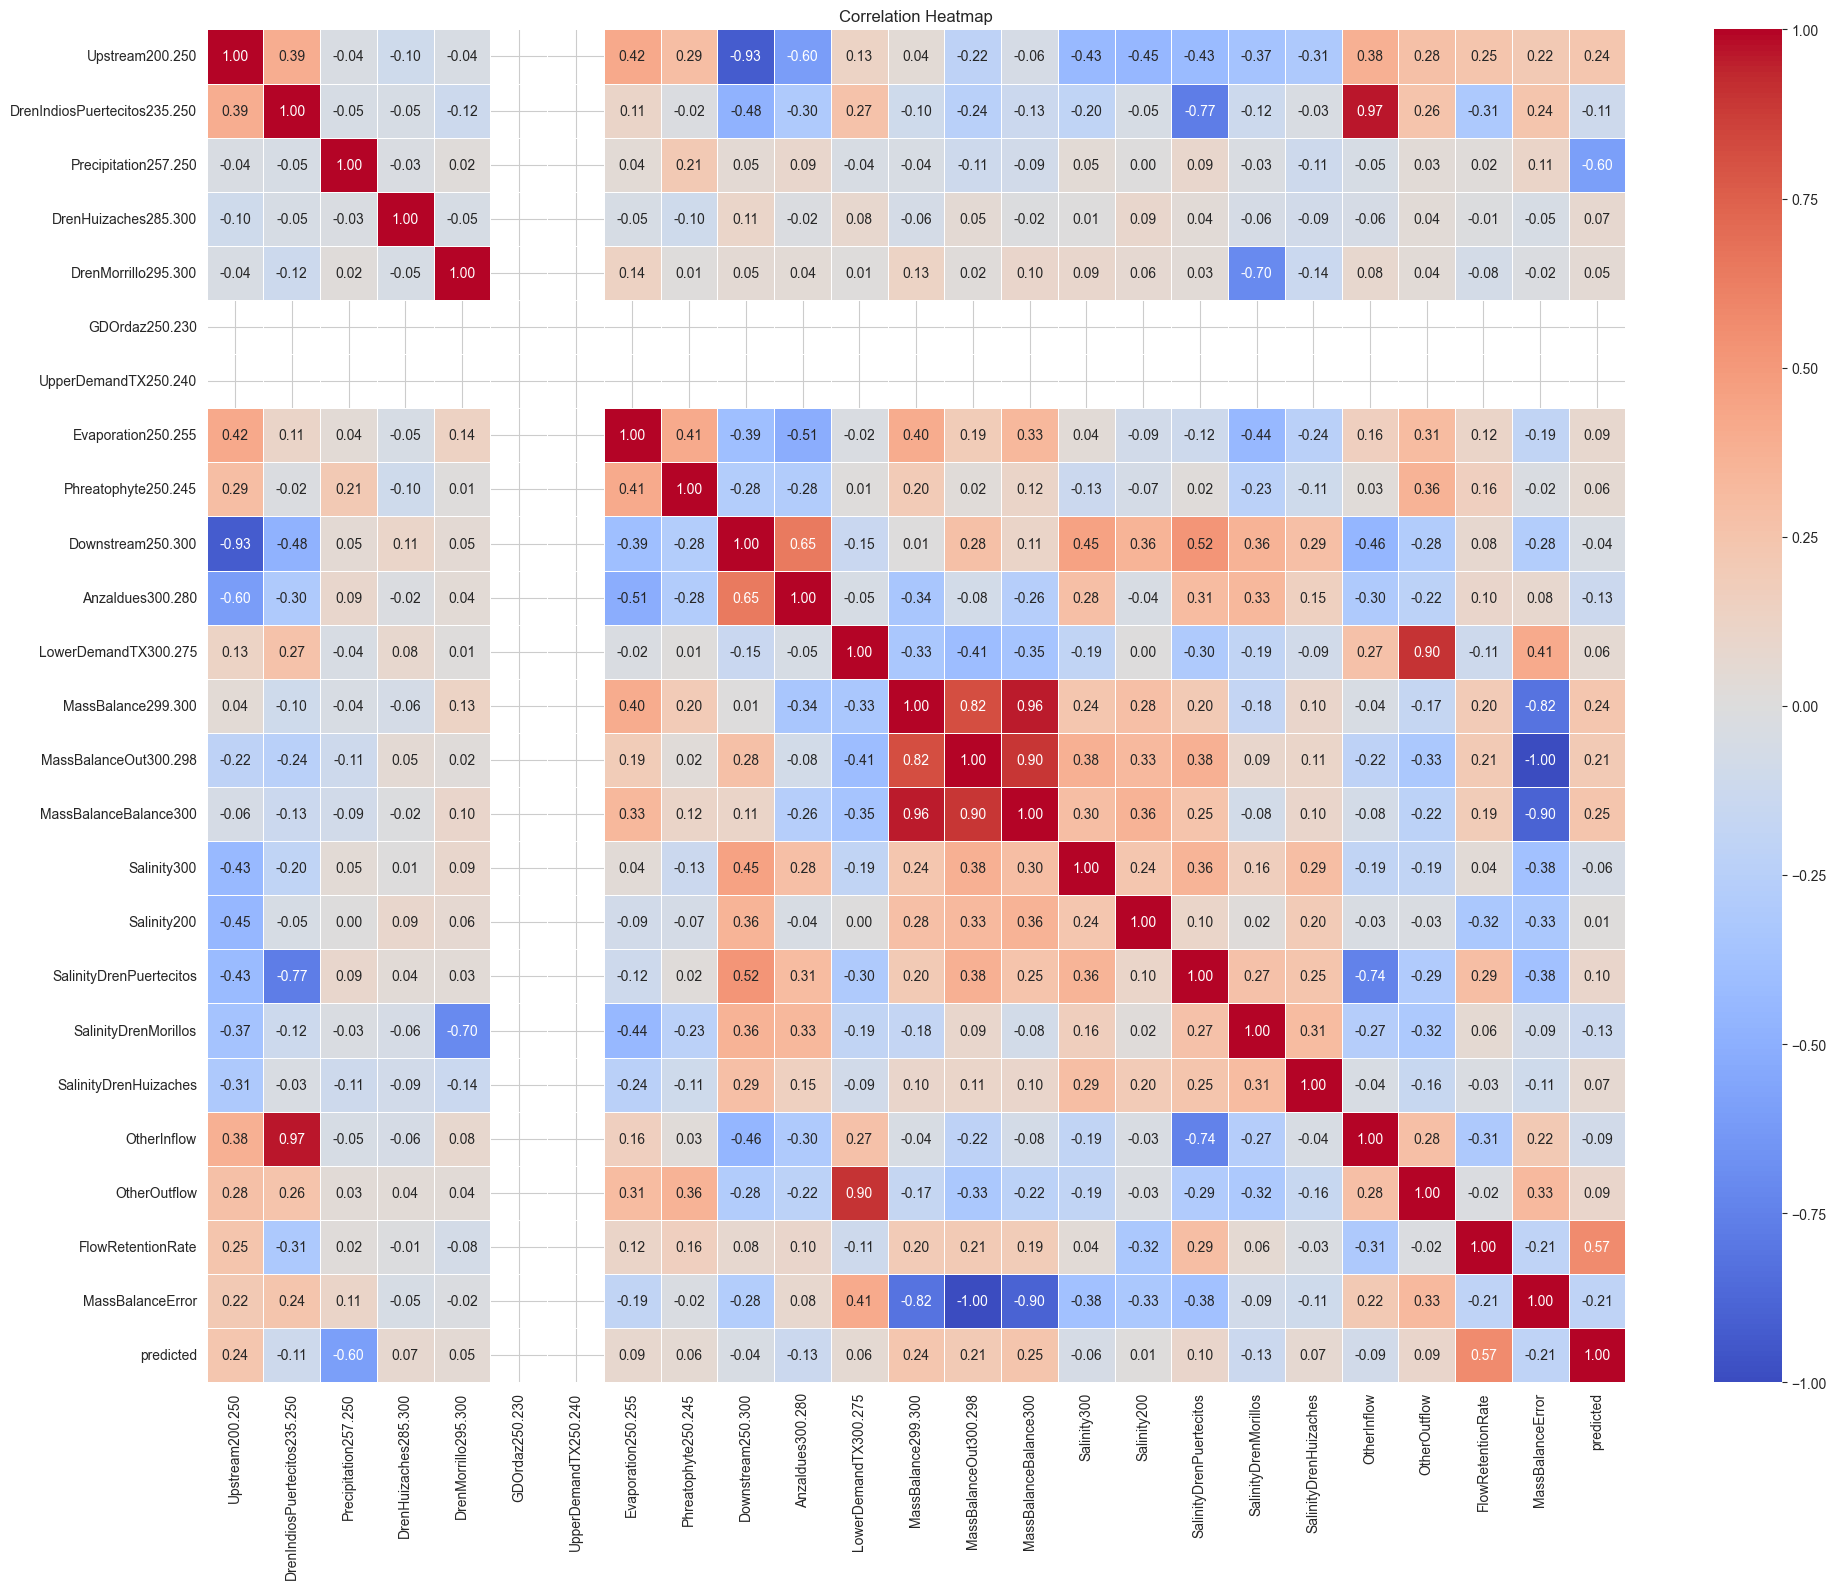

In [41]:
stats.plot_correlation_heatmap(df)


Upstream200.250

ADF Statistic: -2.954113790276162
p-value: 0.039407512870873004
Critical Values: 
	 1%: -3.448544133483233
	 5%: -2.8695574079525565
	 10%: -2.5710411593052713


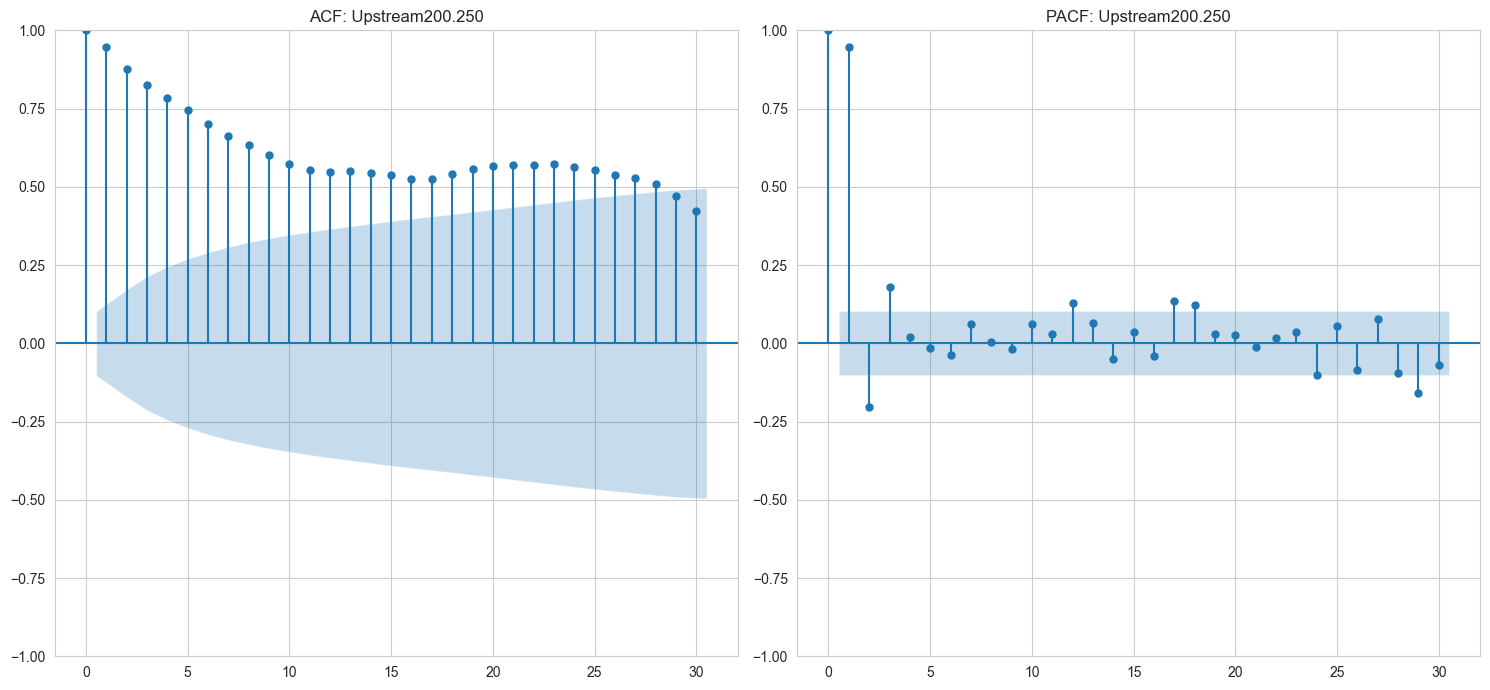


DrenIndiosPuertecitos235.250

ADF Statistic: -2.862421133754933
p-value: 0.04989567328071976
Critical Values: 
	 1%: -3.448493650810824
	 5%: -2.8695352280356556
	 10%: -2.5710293341377715


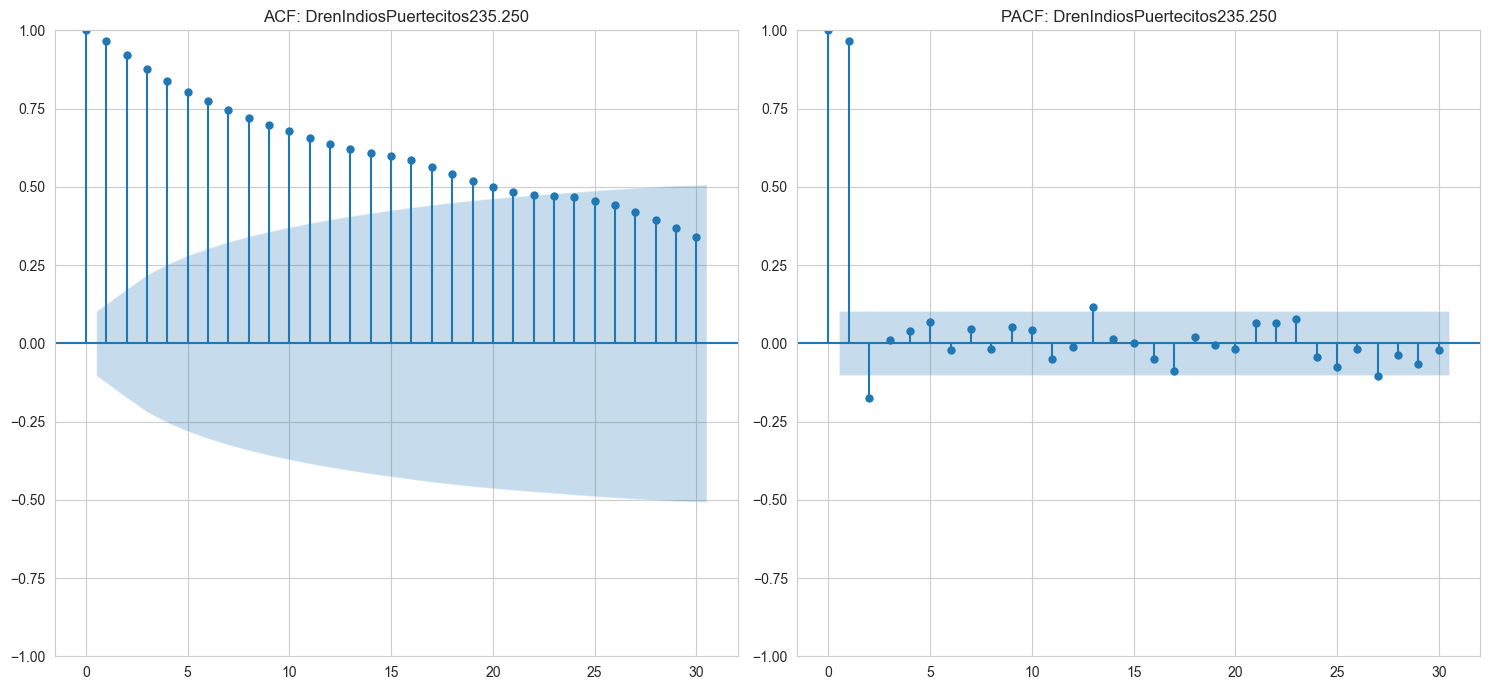


Precipitation257.250

ADF Statistic: -15.28819131258631
p-value: 4.480715011158377e-28
Critical Values: 
	 1%: -3.4484434475193777
	 5%: -2.869513170510808
	 10%: -2.571017574266393


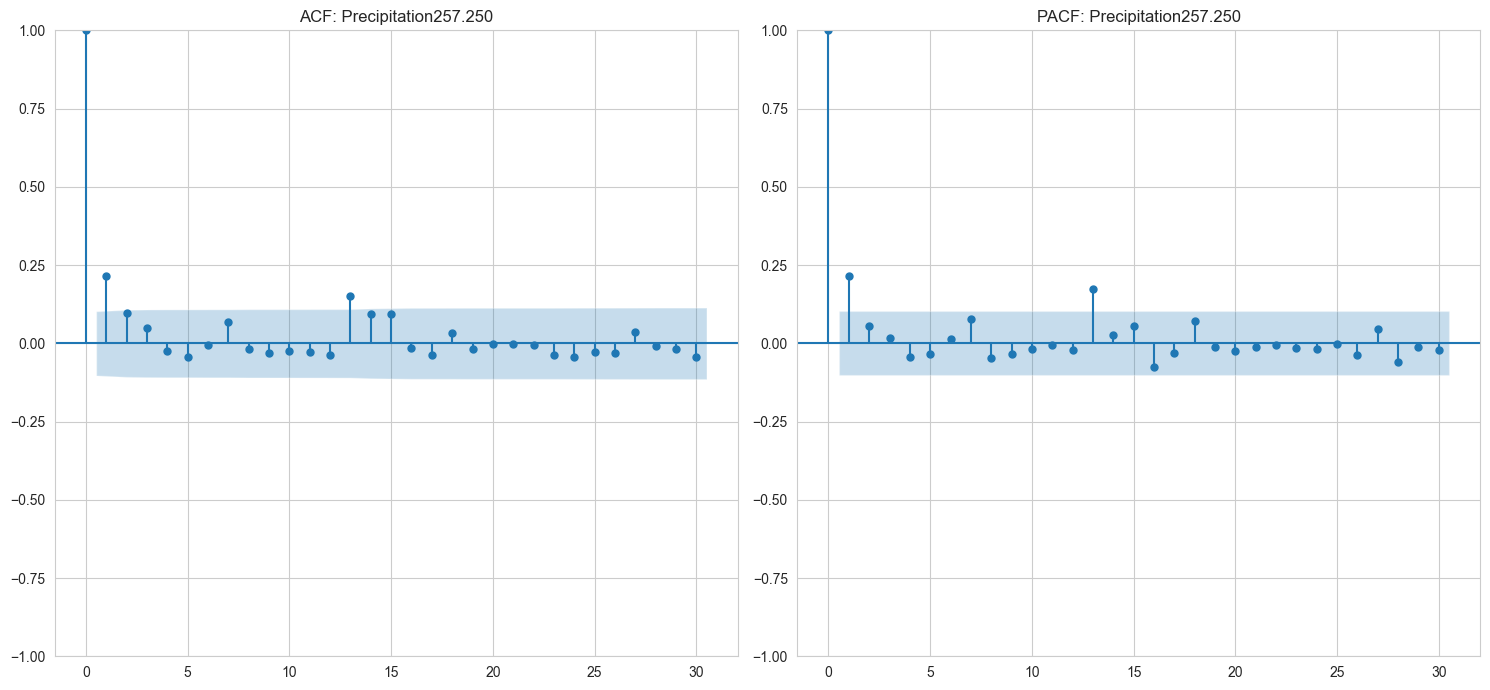


DrenHuizaches285.300

ADF Statistic: -3.7371310140158944
p-value: 0.003620172805311851
Critical Values: 
	 1%: -3.448905534655263
	 5%: -2.8697161816205705
	 10%: -2.5711258103550882


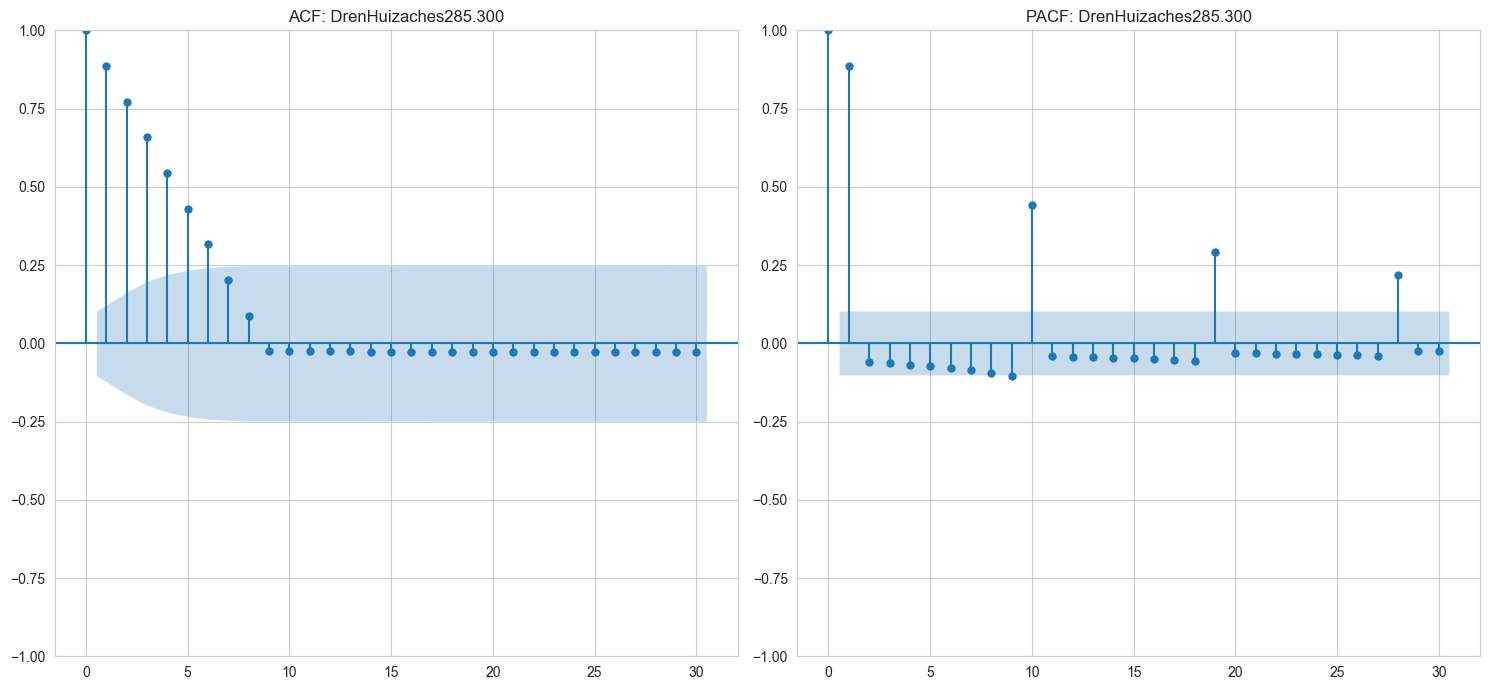


Anzaldues300.280

ADF Statistic: -3.0493185718179254
p-value: 0.03053836242741309
Critical Values: 
	 1%: -3.448544133483233
	 5%: -2.8695574079525565
	 10%: -2.5710411593052713


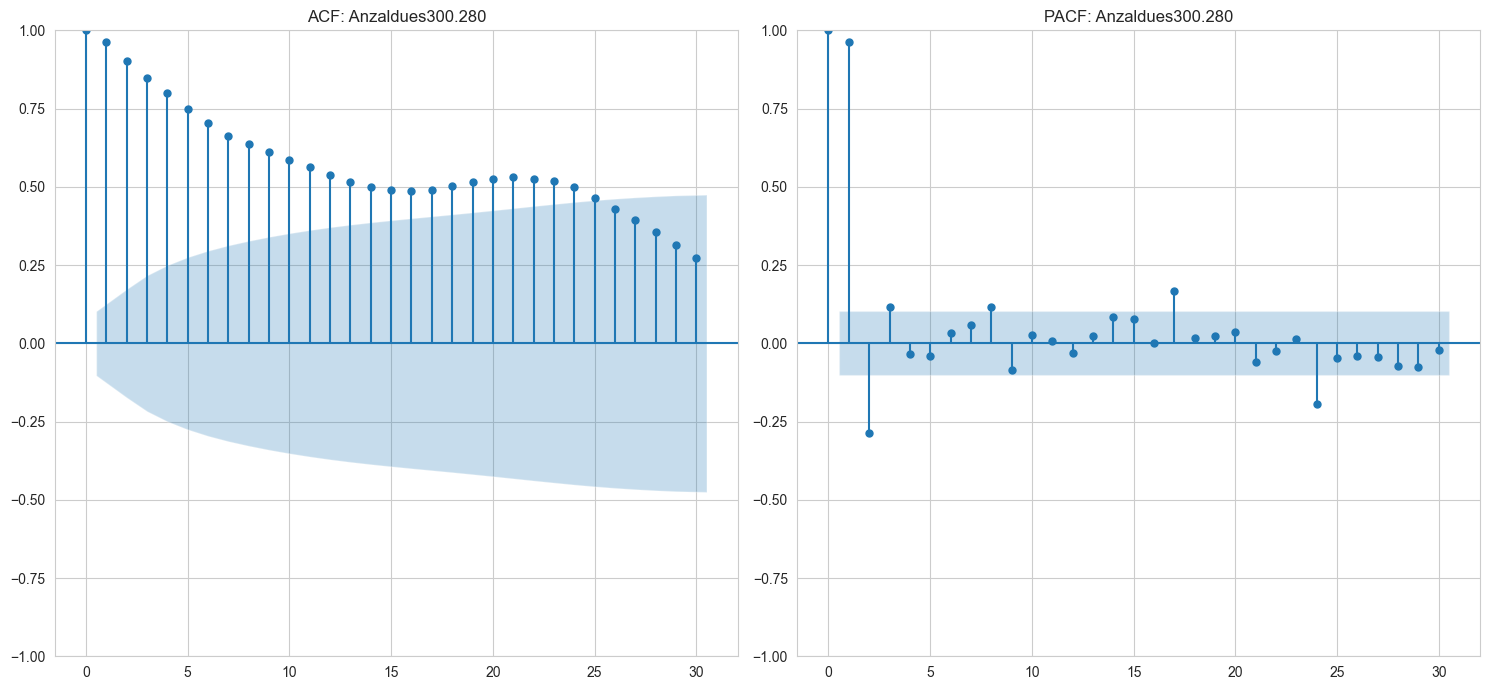


LowerDemandTX300.275

ADF Statistic: -3.7623141026337317
p-value: 0.0033173013065544796
Critical Values: 
	 1%: -3.4489583388155194
	 5%: -2.869739378430086
	 10%: -2.5711381780459


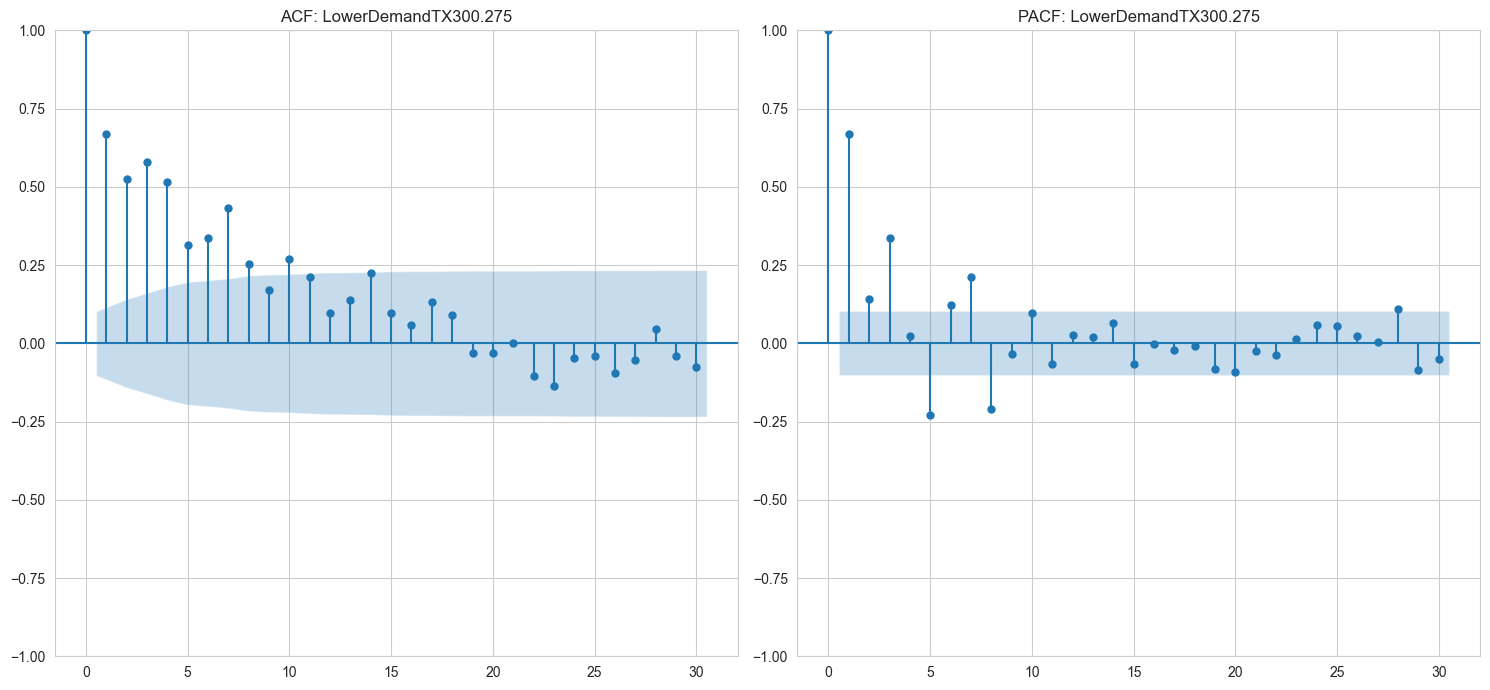


MassBalance299.300

ADF Statistic: -5.118697564718776
p-value: 1.2854805968208352e-05
Critical Values: 
	 1%: -3.4485948978753314
	 5%: -2.86957971128312
	 10%: -2.571053050314224


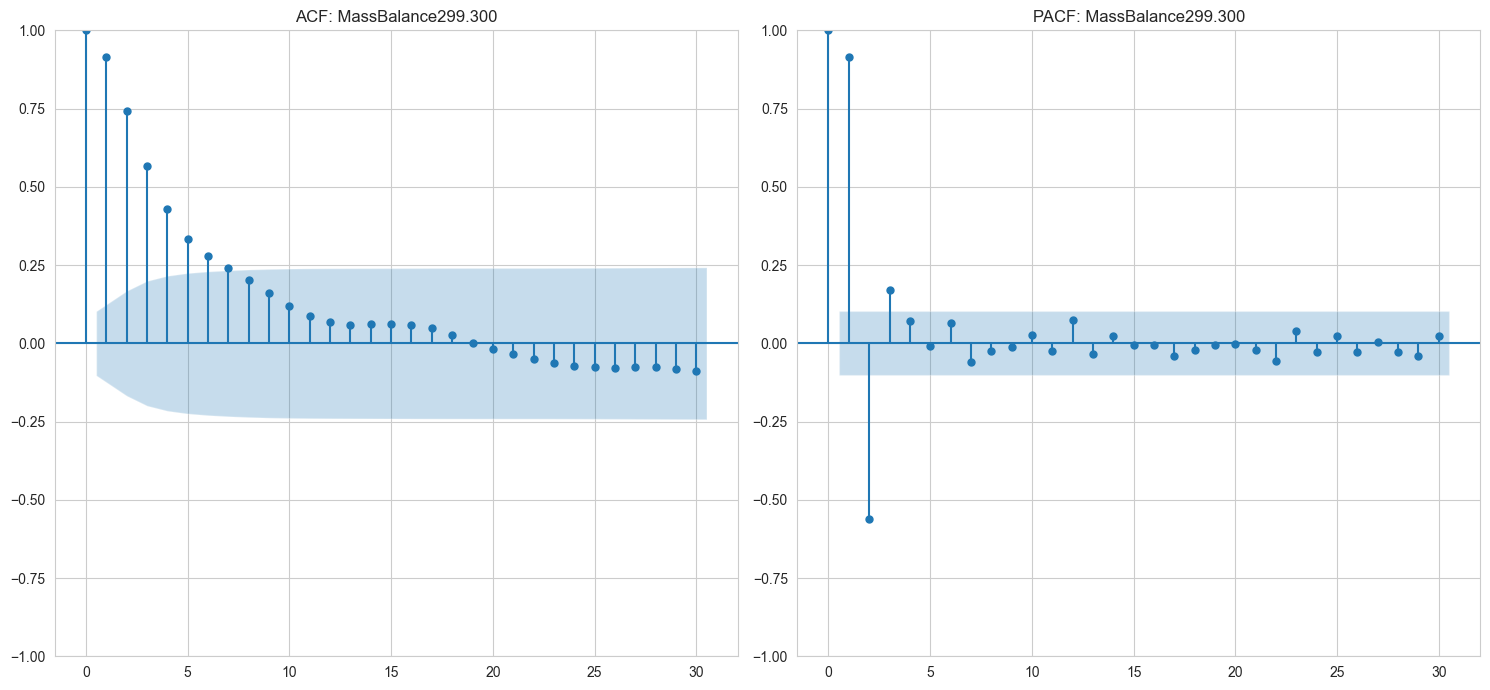


MassBalanceOut300.298

ADF Statistic: -4.272228999753886
p-value: 0.0004960581004754921
Critical Values: 
	 1%: -3.448544133483233
	 5%: -2.8695574079525565
	 10%: -2.5710411593052713


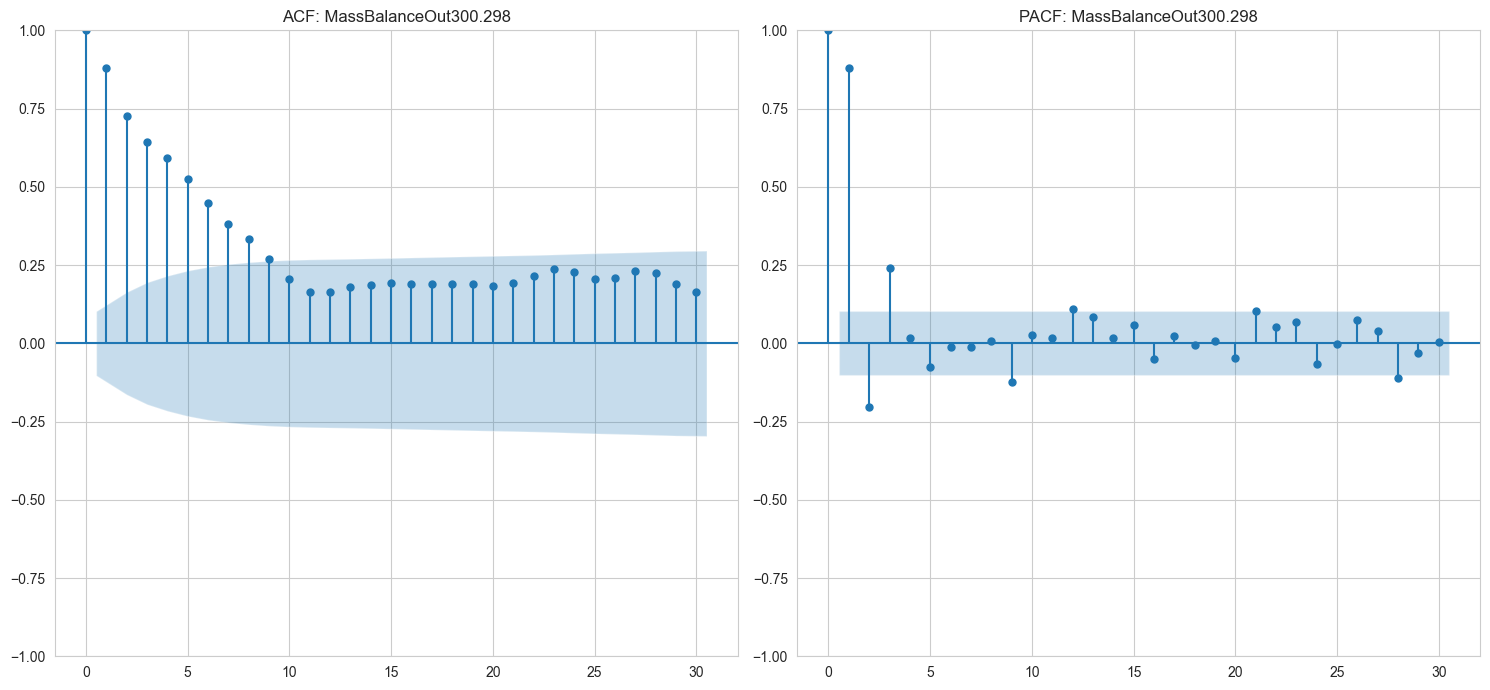


MassBalanceBalance300

ADF Statistic: -5.226487872758735
p-value: 7.760848999042566e-06
Critical Values: 
	 1%: -3.448544133483233
	 5%: -2.8695574079525565
	 10%: -2.5710411593052713


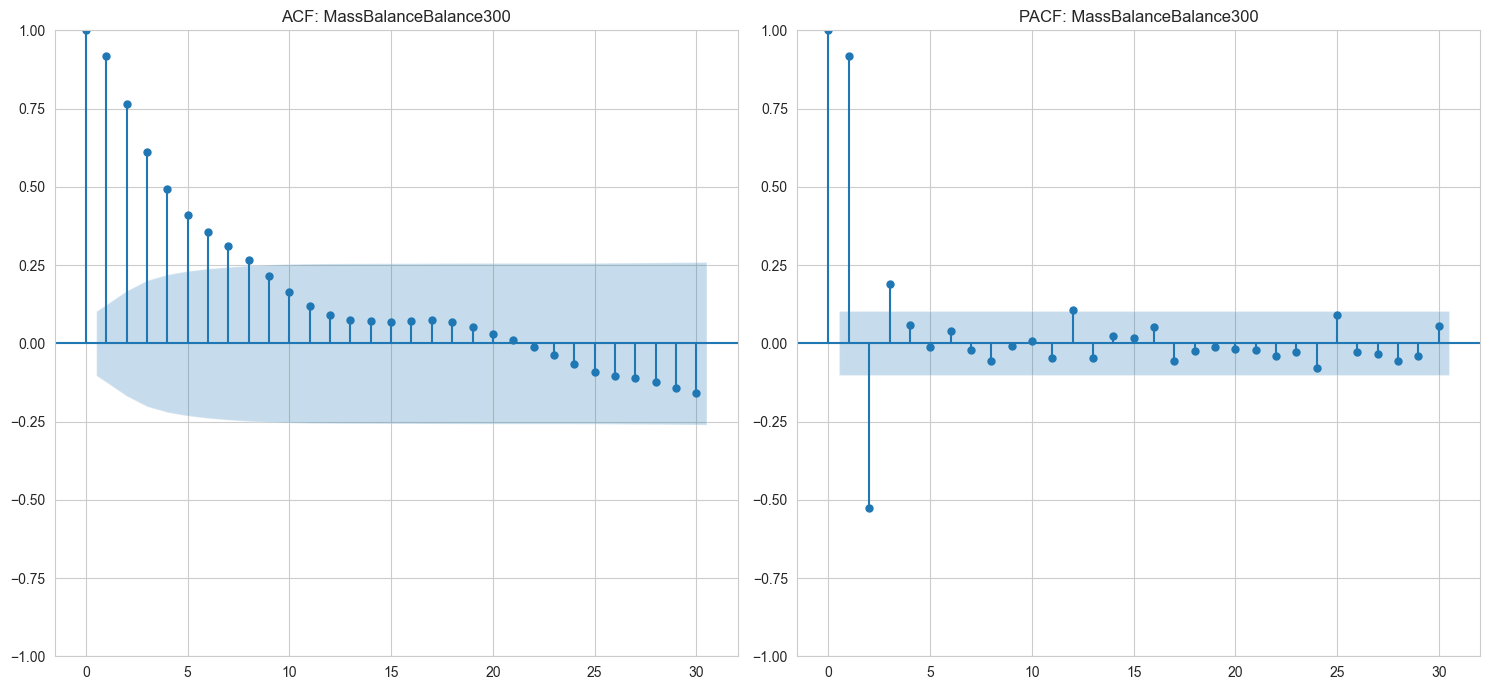


Salinity300

ADF Statistic: -3.898871755166714
p-value: 0.0020431660747300077
Critical Values: 
	 1%: -3.4548957220044336
	 5%: -2.8723451788613157
	 10%: -2.572527778361272


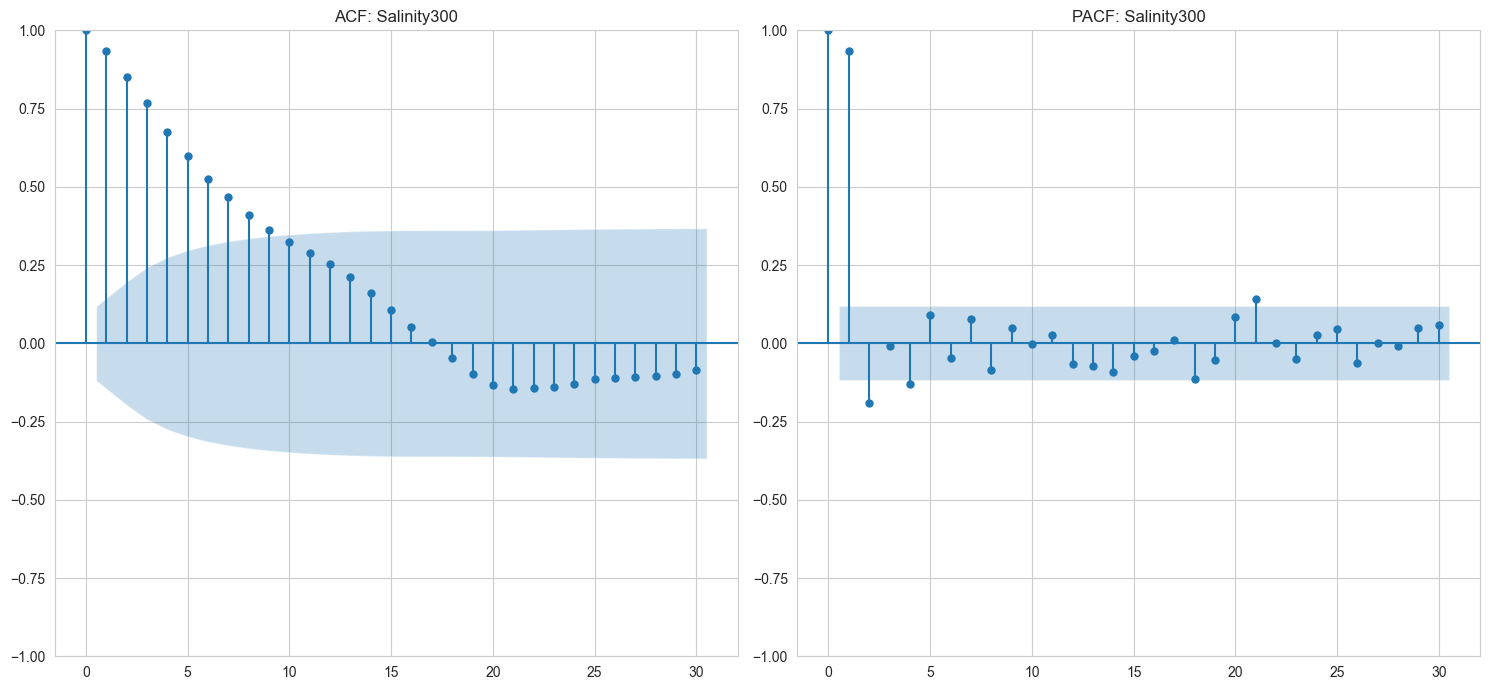


Salinity200

ADF Statistic: -4.828224699019259
p-value: 4.8012990467258104e-05
Critical Values: 
	 1%: -3.448645946352023
	 5%: -2.869602139060357
	 10%: -2.5710650077160495


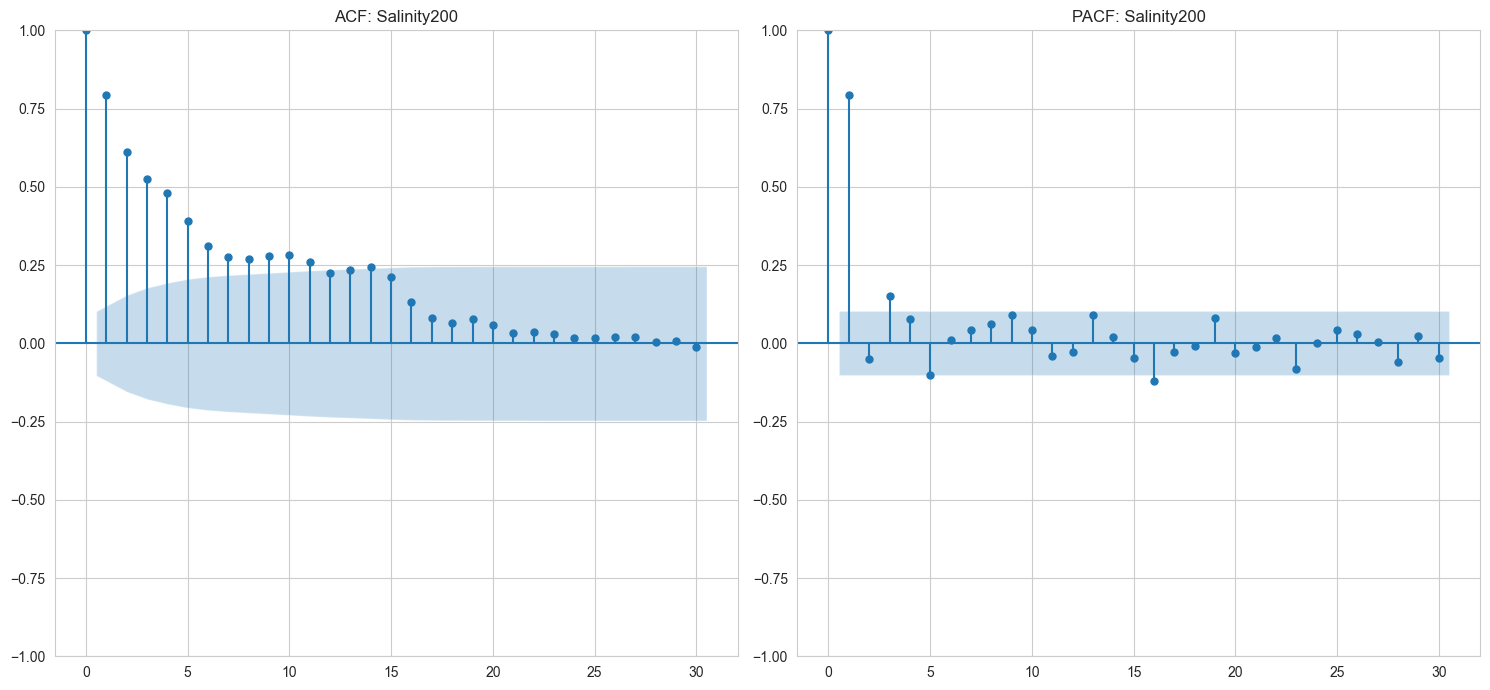


SalinityDrenPuertecitos

ADF Statistic: -3.190666995320067
p-value: 0.02053130606808221
Critical Values: 
	 1%: -3.4500219858626227
	 5%: -2.870206553997666
	 10%: -2.571387268879483


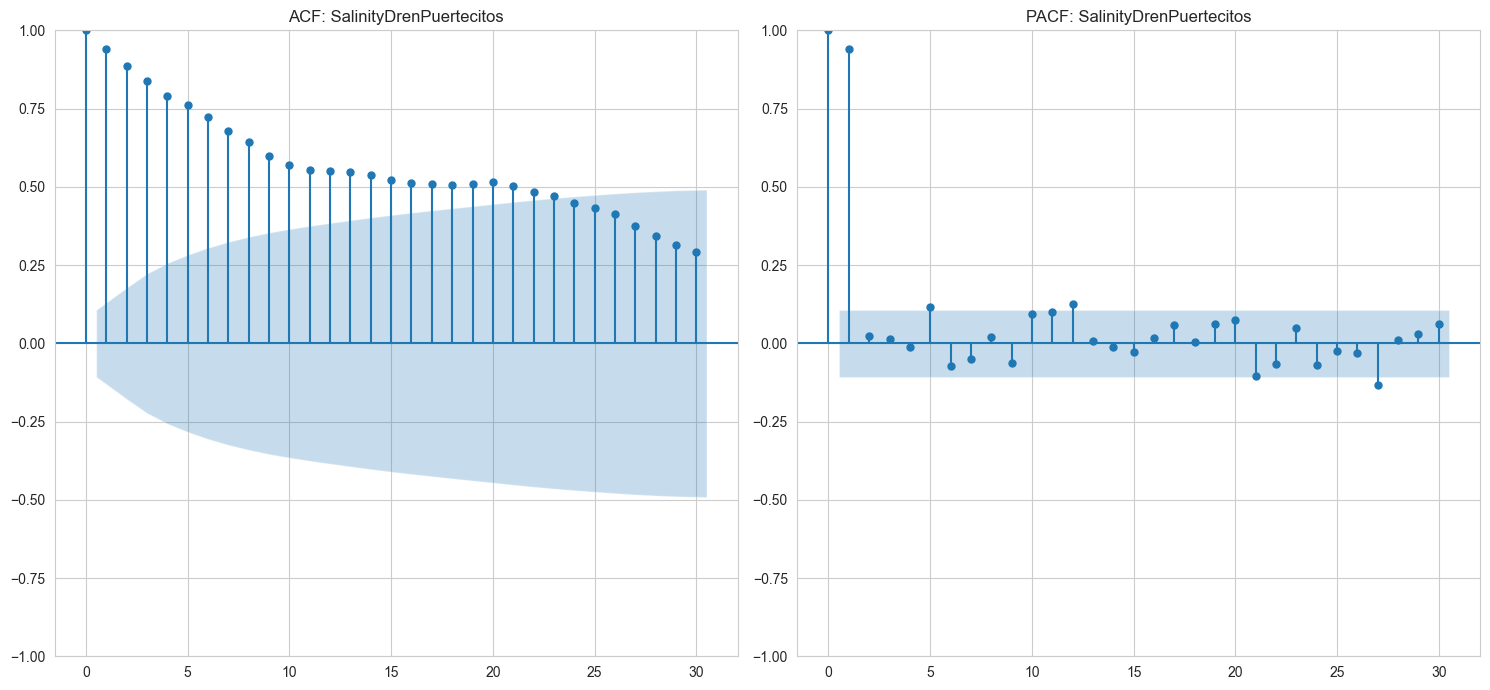


SalinityDrenHuizaches

ADF Statistic: -5.870190222317856
p-value: 3.253945209675313e-07
Critical Values: 
	 1%: -3.4489583388155194
	 5%: -2.869739378430086
	 10%: -2.5711381780459


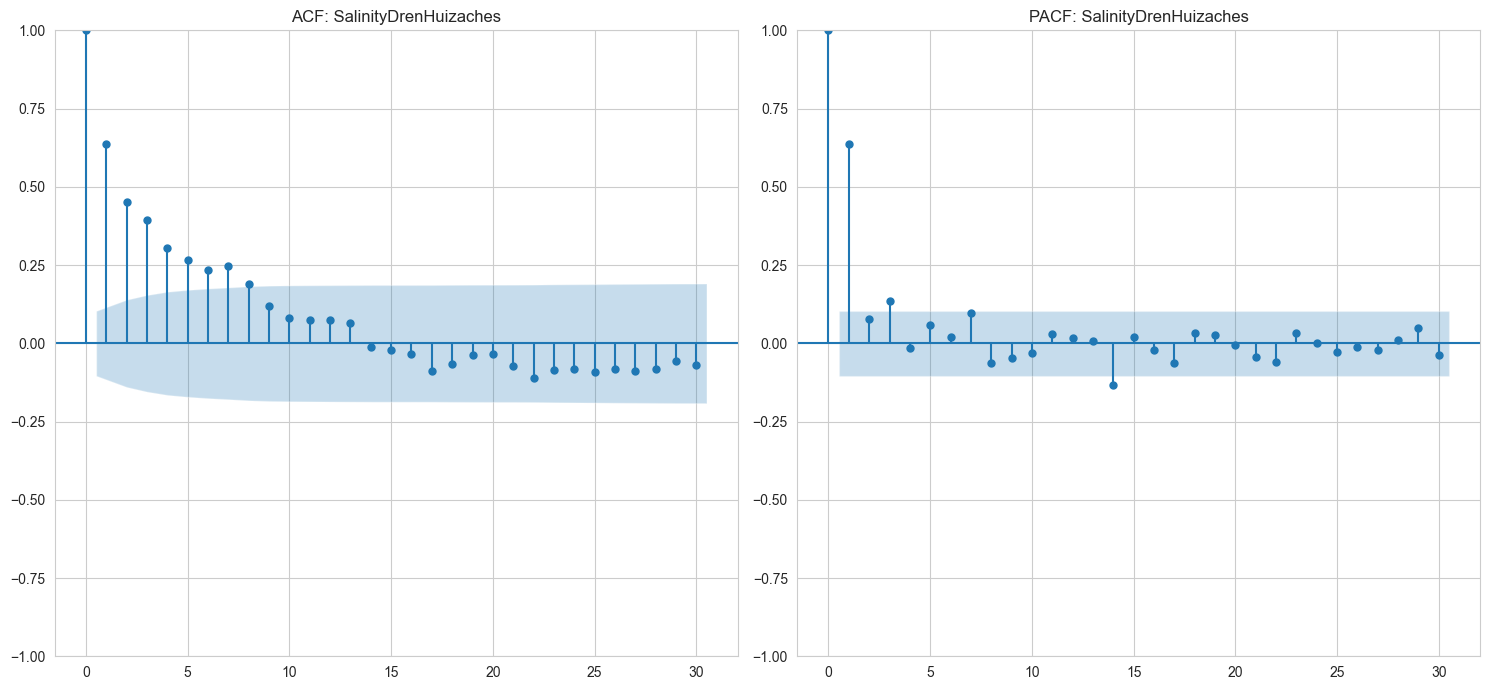


OtherOutflow

ADF Statistic: -2.951849790917733
p-value: 0.03964229979546953
Critical Values: 
	 1%: -3.44911857009962
	 5%: -2.8698097654570507
	 10%: -2.5711757061225153


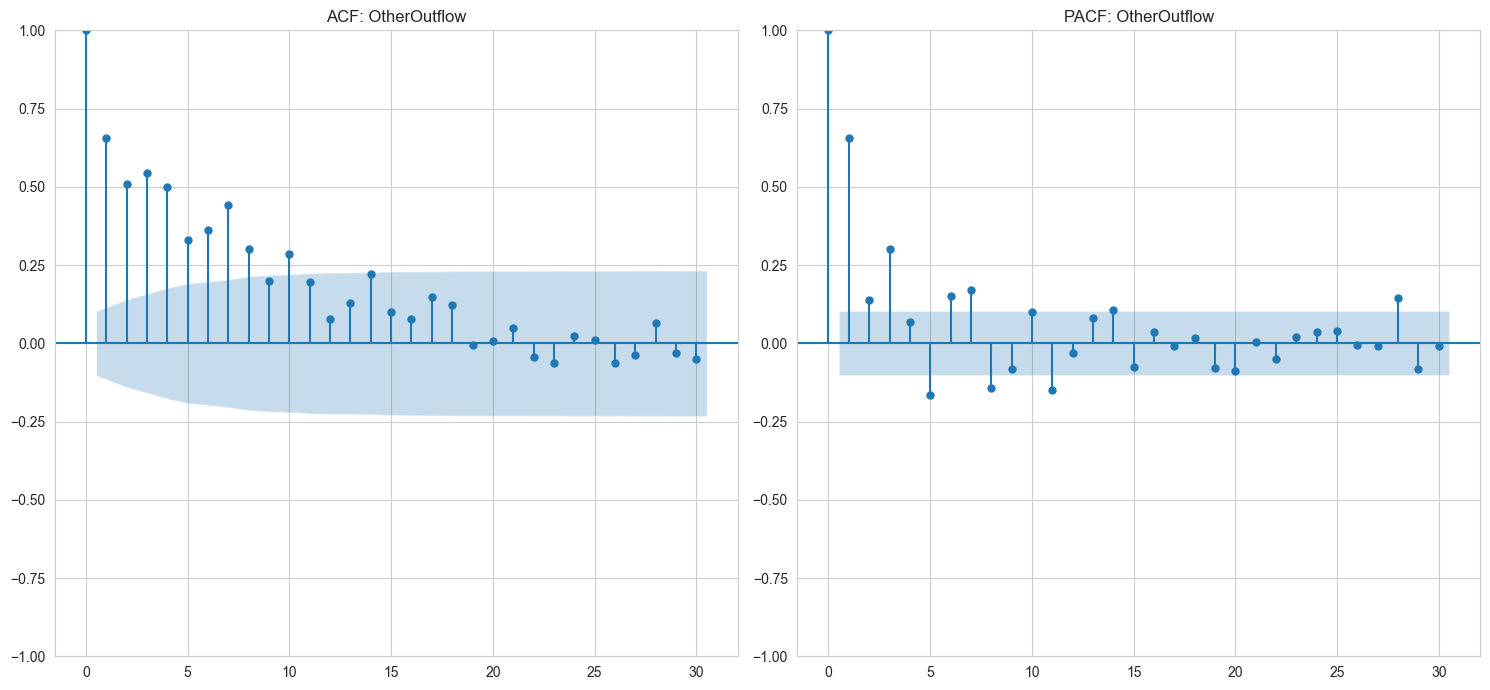


FlowRetentionRate

ADF Statistic: -6.682566756374706
p-value: 4.305295162379087e-09
Critical Values: 
	 1%: -3.4485948978753314
	 5%: -2.86957971128312
	 10%: -2.571053050314224


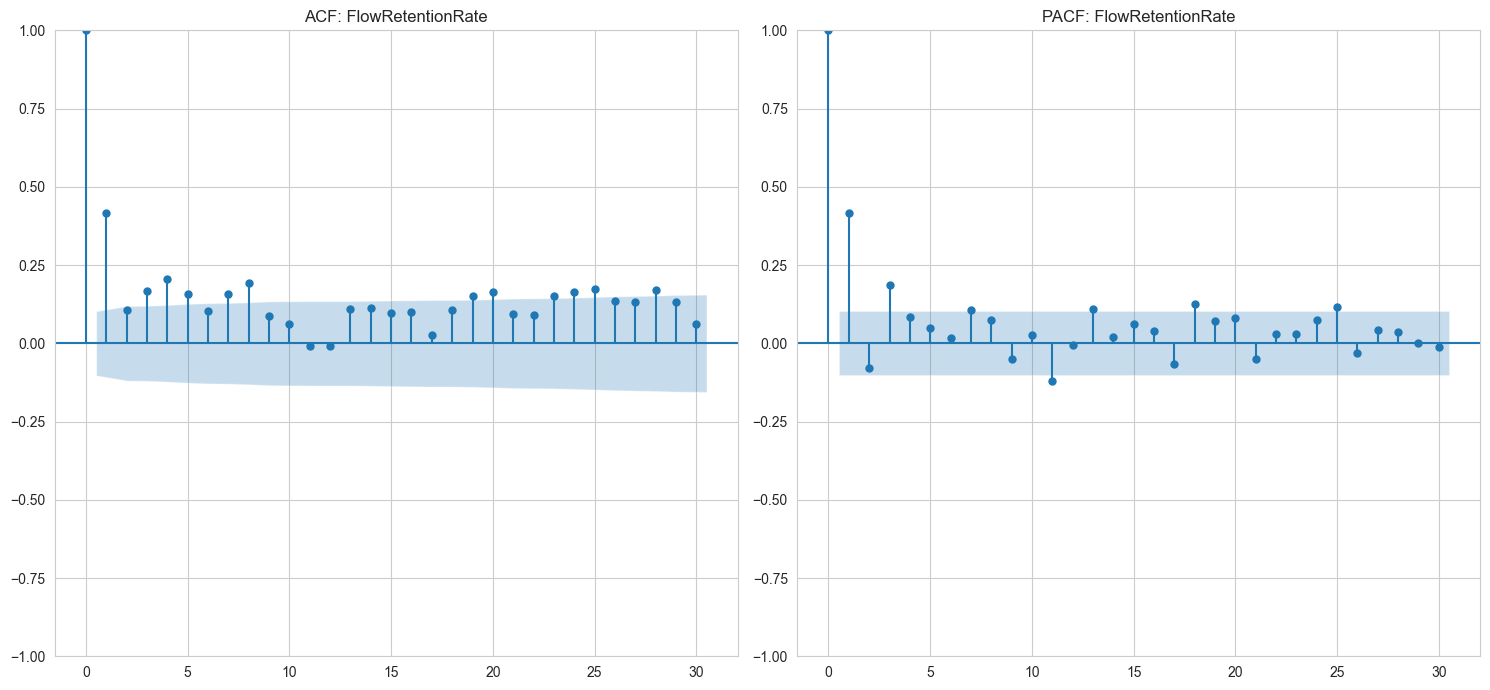


MassBalanceError

ADF Statistic: -4.272228999753886
p-value: 0.0004960581004754921
Critical Values: 
	 1%: -3.448544133483233
	 5%: -2.8695574079525565
	 10%: -2.5710411593052713


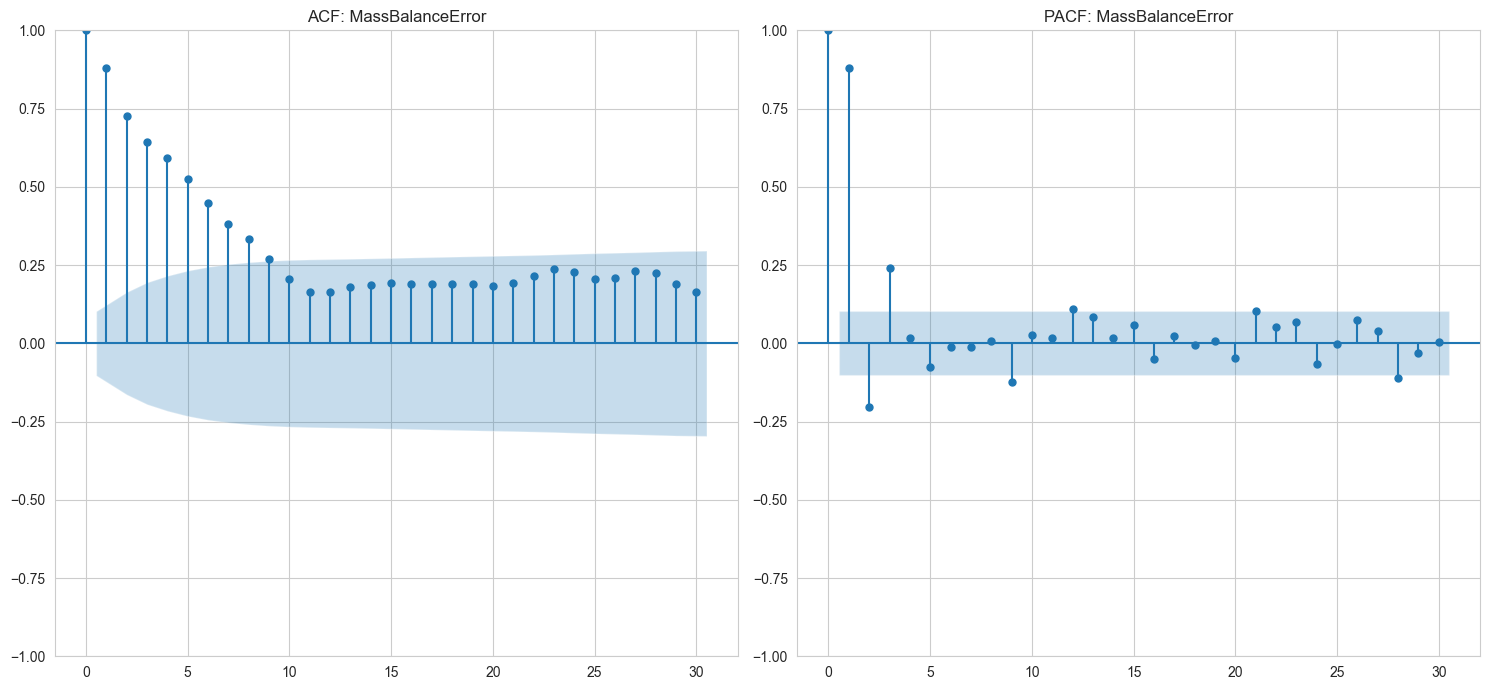

In [13]:
# Check autocorrelation for stationary series
for fn in field_names:
    if stats.check_stationarity(df, fn):
        stats.plot_acf_pacf(df, [fn], lags=30)

In [14]:
# Check for series with trends
for fn in field_names:
    stats.check_stationarity(df, fn, target="nonstationary")


DrenMorrillo295.300 (Nonstationary)

ADF Statistic: -2.552473962432535
p-value: 0.10322305176690127
Critical Values: 
	 1%: -3.448544133483233
	 5%: -2.8695574079525565
	 10%: -2.5710411593052713

Evaporation250.255 (Nonstationary)

ADF Statistic: -1.7275695835830516
p-value: 0.41696668703508044
Critical Values: 
	 1%: -3.4490114443793214
	 5%: -2.8697627072503757
	 10%: -2.5711506161673716

Phreatophyte250.245 (Nonstationary)

ADF Statistic: -2.448102722407619
p-value: 0.1286172880555434
Critical Values: 
	 1%: -3.449336554273722
	 5%: -2.8699055166063085
	 10%: -2.571226758215748

Downstream250.300 (Nonstationary)

ADF Statistic: -2.6588301820844173
p-value: 0.08143737386872962
Critical Values: 
	 1%: -3.448544133483233
	 5%: -2.8695574079525565
	 10%: -2.5710411593052713

OtherInflow (Nonstationary)

ADF Statistic: -2.833828335886813
p-value: 0.05360173930773931
Critical Values: 
	 1%: -3.448493650810824
	 5%: -2.8695352280356556
	 10%: -2.5710293341377715


# Test 1: Are precipitation events correlated with salinity spikes?

There is an observation from the graphical analysis that salinity spikes seem to occur after rainfall. To test this hypothesis, I check the error based on the salinity formula given for local drainage including the 2 day moving average of the precipitation flows on the river surface as `flow_local` (just to smooth things). From this I approximate the c_local using parameterized curve fitting. 

```
    c_out = (c_in * flow_in + c_local * flow_local) / (-1 * flow_out)
```



Optimized parameter: 393.4359424655824
Length of y_data_valid: 257
Length of y_fit_valid: 257
Unique values in y_data_valid: 169
Unique values in y_fit_valid: 257
Mean Squared Error: 145277.2350228148
Mean Absolute Error: 277.35981860167044
Pearson Correlation: 0.06392656622443192
Spearman Correlation: nan


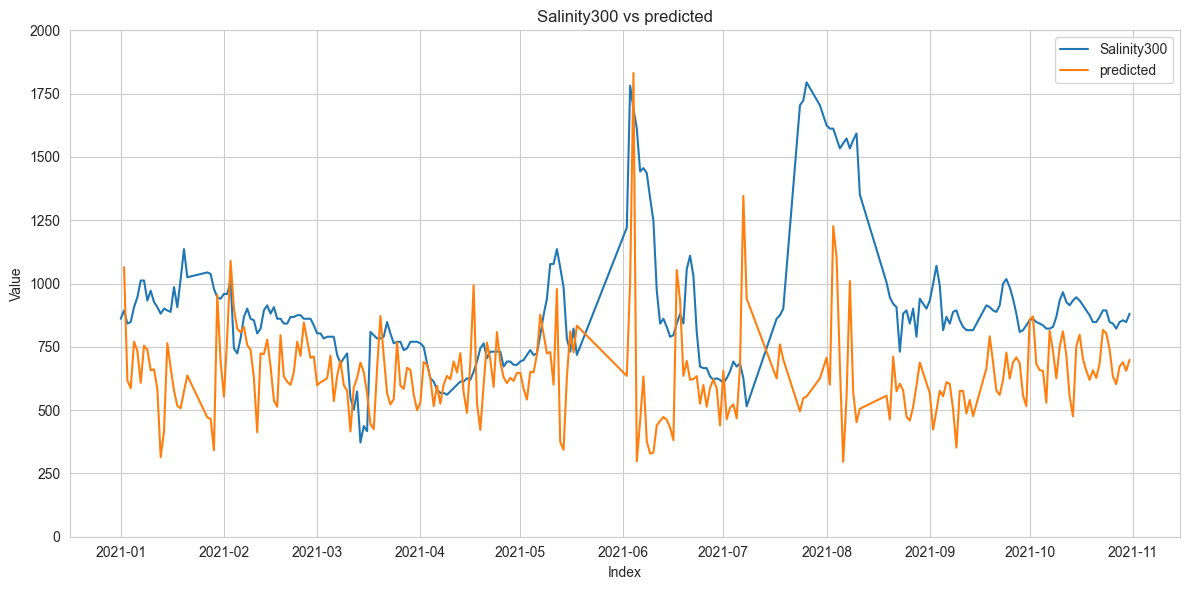

In [107]:
# Known values for the other parameters (these are fixed for the fitting process)
flow_local = analysis.moving_average(df["Precipitation257.250"], 2)
flow_in = df["Upstream200.250"]
c_in = analysis.moving_average(df["Salinity200"],2)
flow_out = df["Downstream250.300"] + df["OtherOutflow"]
x_data = np.array([flow_local, flow_in, flow_out, c_in])

# Fit the curve on c_local, adjusting it to minimize the error
# Compare against smoothed salinity
# Median Salinity For Non-Point Sources in stormwater runoff (Dirrigl et al, 2016)
optimal_sal = analysis.regression_error(
    model_function=analysis.base_salinity_function,
    x_data=x_data,
    y_data=analysis.moving_average(df["Salinity300"],2),
    p0=[671.],
    bounds=((0,10000)),
)

df["predicted"] = analysis.base_salinity_function(
    X=x_data,
    c_local=optimal_sal,
)

# Plot the predicted function over the points
plot.plot_two_columns(df, "Salinity300", "predicted", smooth=False)

![ref2.jpg](ref2.jpg)

### That looks okay...

How about we also use the data from Miguel Pavon covering the cache basin?

In [96]:
# Supplemental information on rainfall in the entire cache basin (not just on the surface)
# Assumes rye run huc2sqlite has been run with all relevant AOI

df_huc_2N = pd.read_csv("data/Rain_Ave_Date_2N.csv", header=0)
df_huc_2S = pd.read_csv("data/Rain_Ave_Date_2S.csv", header=0)

df_huc_2N['timestamp'] = pd.to_datetime(df_huc_2N['Date_Text'], format='%Y%m%d')
df_huc_2S['timestamp'] = pd.to_datetime(df_huc_2S['Date_Text'], format='%Y%m%d')

# Join the data together on the timestamp
df_huc = df_huc_2N[["timestamp"]].assign(mean_precip=df_huc_2N["mean_precip"] + df_huc_2S["mean_precip"])

# Filter out irrelevant rows based on timestamp
start = pd.to_datetime("01/01/2021")
end = pd.to_datetime("12/31/2021")
df_huc = df_huc[(df_huc['timestamp'] >= start) & (df_huc['timestamp'] <= end)]

# Update the index to be the timestamp
df_huc.set_index('timestamp', inplace=True)

# Optional: Sort the index (timestamps) if needed
df_huc.sort_index(inplace=True)

# Add to the main df
df["AOI_rainfall"] = df_huc["mean_precip"]

Optimized parameter: 266.2393727974446
Mean Squared Error: 143883.2858711227
Mean Absolute Error: 275.42705870079647
Pearson Correlation: 0.06667634264108098
Spearman Correlation: nan


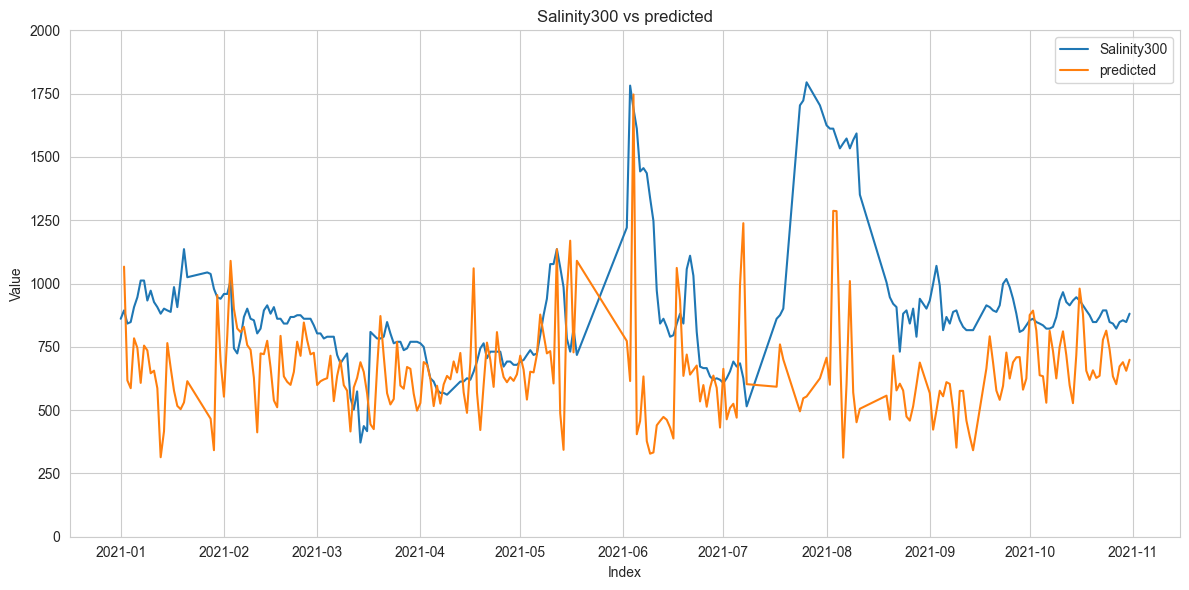

In [102]:
# Known values for the other parameters (these are fixed for the fitting process)
flow_local = analysis.moving_average(df["AOI_rainfall"], 2) 
flow_in = df["Upstream200.250"]
c_in = analysis.moving_average(df["Salinity200"],2)
flow_out = df["Downstream250.300"] + df["OtherOutflow"]
x_data = np.array([flow_local, flow_in, flow_out, c_in])

# Fit the curve on c_local, adjusting it to minimize the error
# Compare against smoothed salinity
# Median Salinity For Non-Point Sources in stormwater runoff (Dirrigl et al, 2016)
optimal_sal = analysis.regression_error(
    model_function=analysis.base_salinity_function,
    x_data=x_data,
    y_data=analysis.moving_average(df["Salinity300"],2),
    p0=[671.],
    bounds=((0,10000)),
)

df["predicted"] = analysis.base_salinity_function(
    X=x_data,
    c_local=optimal_sal,
)

# Plot the predicted function over the points
plot.plot_two_columns(df, "Salinity300", "predicted", smooth=False)